<a href="https://colab.research.google.com/github/VidurMushran/NEvL_but_automated/blob/main/NEvL_but_Morphometrics_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set

In [ ]:
random_state = 42

## Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%cd '/content/drive/MyDrive/Research/CURE/NEvL but Morphometrics/'
%ls

/content/drive/MyDrive/Research/CURE/NEvL but Morphometrics
 catboost_info/                               'NEvL but Morphometrics v2.ipynb'
 counts_dataframe_1.csv                       'NEvL but Morphometrics v3.ipynb'
 counts_dataframe_2.csv                       'NEvL Classification.ipynb'
 dapineg_df_1.csv                             'NEvL Classification Reports.gsheet'
 dapineg_df_2.csv                              NEvL+ND_df.csv
 dapipos_df_1.csv                              NEvL_slide_and_patient_IDs.csv
 dapipos_df_2.csv                              output.html
 galleries/                                    __pycache__/
 InteractiveSheet_2024-08-02_20_54_04.gsheet   temp.png
 interpretable_knn.py                          updated_data.csv
 manual_classification.csv                     xgboost_tree
 models/                                       xgboost_tree.png
'ND_manual validated_20240726.csv'


## Import

In [ ]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [ ]:
pd.set_option('display.width', 500)

## Util

In [ ]:
!pip install imblearn

In [ ]:
from sklearn.model_selection import GroupShuffleSplit, StratifiedGroupKFold
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks, EditedNearestNeighbours, RepeatedEditedNearestNeighbours, AllKNN, CondensedNearestNeighbour, NeighbourhoodCleaningRule, OneSidedSelection, InstanceHardnessThreshold
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, KMeansSMOTE, SVMSMOTE, SMOTENC, SMOTEN, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import MiniBatchKMeans

def patient_level_split(df, X_cols, random_state):
  X = df.loc[:, X_cols].fillna(0)

  NotX = df.drop(columns=X_cols)
  gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)
  for i, (train_index, test_index) in enumerate(gss.split(X, NotX, NotX['patient_id'])):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      NotX_train, NotX_test = NotX.iloc[train_index], NotX.iloc[test_index]

  print(f'X_train: {X_train.shape}, X_test: {X_test.shape}, NotX_train: {NotX_train.shape}, NotX_test: {NotX_test.shape}')

  return X_train, X_test, NotX_train, NotX_test

def scale_by_train(X_train, X_test):
  scaler = StandardScaler()
  scaler.fit(X_train)
  X_train_cols = X_train.columns.values.tolist()

  X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train_cols)
  X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_train_cols)

  return X_train_scaled, X_test_scaled

def sampler(kind, X_train, NotX_train, y_train, random_state):
  match kind:
    case 'RandomUnderSampler':
      samp = RandomUnderSampler(sampling_strategy='auto', random_state=random_state, replacement=False)
    case 'NearMiss':
      samp = NearMiss(sampling_strategy='auto', version=1, n_neighbors=3, n_neighbors_ver3=3)
    case 'TomekLinks':
      samp = TomekLinks(sampling_strategy='auto')
    case 'EditedNearestNeighbours':
      samp = EditedNearestNeighbours(sampling_strategy='auto', n_neighbors=3, kind_sel='all')
    case 'RepeatedEditedNearestNeighbours':
      samp = RepeatedEditedNearestNeighbours(sampling_strategy='auto', n_neighbors=3, max_iter=100, kind_sel='all')
    case 'AllKNN':
      samp = AllKNN(sampling_strategy='auto', n_neighbors=3, kind_sel='all', allow_minority=False)
    case 'CondensedNearestNeighbour':
      samp = CondensedNearestNeighbour(sampling_strategy='auto', random_state=random_state, n_neighbors=None, n_seeds_S=1)
    case 'NeighbourhoodCleaningRule':
      samp = NeighbourhoodCleaningRule(sampling_strategy='auto', edited_nearest_neighbours=None, n_neighbors=3, kind_sel='deprecated', threshold_cleaning=0.5)
    case 'OneSidedSelection':
      samp = OneSidedSelection(sampling_strategy='auto', random_state=random_state, n_neighbors=None, n_seeds_S=1,)
    case 'InstanceHardnessThreshold':
      samp = InstanceHardnessThreshold(estimator=LogisticRegression(), sampling_strategy='auto', random_state=random_state, cv=5)
    case 'ClusterCentroids':
      samp = ClusterCentroids(sampling_strategy='auto', random_state=random_state, estimator=None, voting='auto')
    case 'RandomOverSampler':
      samp = RandomOverSampler(sampling_strategy='auto', random_state=random_state, shrinkage=None)
    case 'SMOTE':
      samp = SMOTE(sampling_strategy='auto', random_state=random_state, k_neighbors=5)
    case 'BorderlineSMOTE-1':
      samp = BorderlineSMOTE(sampling_strategy='auto', random_state=random_state, k_neighbors=5, m_neighbors=10, kind='borderline-1')
    case 'BorderlineSMOTE-2':
      samp = BorderlineSMOTE(sampling_strategy='auto', random_state=random_state, k_neighbors=5, m_neighbors=10, kind='borderline-2')
    case 'KMeansSMOTE':
      samp = KMeansSMOTE(sampling_strategy='auto', random_state=random_state, k_neighbors=2, kmeans_estimator=None, cluster_balance_threshold='auto', density_exponent='auto')
    case 'SVMSMOTE':
      samp = SVMSMOTE(sampling_strategy='auto', random_state=random_state, k_neighbors=5, m_neighbors=10, svm_estimator=None, out_step=0.5)
    case 'ADASYN':
      samp = ADASYN(sampling_strategy='auto', random_state=random_state, n_neighbors=5)
    case 'SMOTEENN':
      samp = SMOTEENN(sampling_strategy='auto', random_state=random_state, smote=None, enn=None)
    case 'SMOTETomek':
      samp = SMOTETomek(sampling_strategy='auto', random_state=random_state, smote=None, tomek=None)
    case _:
      raise ValueError("Invalid sampler kind")

  X_train_samp, y_train_samp = samp.fit_resample(X_train, y_train)
  NotX_train_samp = NotX_train.iloc[samp.sample_indices_]

  return X_train_samp, y_train_samp, NotX_train_samp

def create_Xy_dict(df, X_cols, y_col, random_state):
  X_train, X_test, NotX_train, NotX_test = patient_level_split(df, X_cols, random_state)
  X_train, X_test = scale_by_train(X_train, X_test)

  y_train, y_test = NotX_train[y_col], NotX_test[y_col]

  dict_name = {
          'X': {'train': X_train, 'test': X_test},
          'NotX': {'train': NotX_train, 'test': NotX_test},
          'y': {'train': y_train, 'test': y_test}
         }
  return dict_name

def extend_Xy_dict_with_samps(data_dict, samp_strategies, random_state):
  for kind in samp_strategies:
    X_train, y_train, NotX_train = sampler(kind, data_dict['X']['train'], data_dict['NotX']['train'], data_dict['y']['train'], random_state)
    data_dict['X'][f'train_{kind}'] = X_train
    data_dict['y'][f'train_{kind}'] = y_train
    data_dict['NotX'][f'train_{kind}'] = NotX_train
    print(f'{kind} complete')
  return data_dict

def screen_stage_multi_dict(df, X_cols, samp_strategies, random_state):
  screen_data_dict = create_Xy_dict(df, X_cols, 'DX', random_state)
  screen_data_dict = extend_Xy_dict_with_samps(screen_data_dict, samp_strategies, random_state)
  print('screen complete')

  stage_data_dict = create_Xy_dict(df[df['DX'] == 'BC'], X_cols, 'DX_multi', random_state)
  stage_data_dict = extend_Xy_dict_with_samps(stage_data_dict, samp_strategies, random_state)
  print('stage complete')

  multi_data_dict = create_Xy_dict(df, X_cols, 'DX_multi', random_state)
  multi_data_dict = extend_Xy_dict_with_samps(multi_data_dict, samp_strategies, random_state)
  print('multi complete')

  data_dict = {
      'screen': screen_data_dict,
      'stage': stage_data_dict,
      'multi': multi_data_dict
  }
  return data_dict

In [ ]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 1.9 MB/s eta 0:00:00


In [ ]:
from umap import UMAP

In [ ]:
def UMAP_plot(umap, X, Y, df_name, columns, y_col):
  X_umap = umap.transform(X)
  Y = pd.factorize(Y, sort=True)
  x = X_umap[:, 0]
  y = X_umap[:, 1]
  c = Y[0].tolist()

  fig, ax = plt.subplots()
  scatter = ax.scatter(x, y, c=c, alpha=0.5, s=5)

  plt.title(f'UMAP on 80% of {df_name} ({columns} columns)')
  plt.xlabel('UMAP 1')
  plt.ylabel('UMAP 2')
  plt.legend(handles=scatter.legend_elements()[0], labels=Y[1].tolist(), title=y_col, bbox_to_anchor=(1.05, 1), loc='upper left')
  plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

def hyp_train(model, grid, X, y, groups):
  sgkf = StratifiedGroupKFold(n_splits=5, random_state=random_state, shuffle=True)
  grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=sgkf, scoring='accuracy', error_score=0)
  grid_result = grid_search.fit(X, y, groups=groups)
  best_model = grid_search.best_estimator_
  best_params = grid_result.best_params_
  print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
  # means = grid_result.cv_results_['mean_test_score']
  # stds = grid_result.cv_results_['std_test_score']
  # params = grid_result.cv_results_['params']
  # for mean, stdev, param in zip(means, stds, params):
  #     print("%f (%f) with: %r" % (mean, stdev, param))
  for key in best_params.keys():
    best_params[key] = [best_params[key]]
  return best_model, best_params

In [ ]:
from sklearn.metrics import roc_auc_score, classification_report, ConfusionMatrixDisplay

def cell_level_y_pred_analysis(model, model_name, X_test, y_test):
  y_pred = model.predict(X_test)
  y_pred_dummied = pd.get_dummies(y_pred)

  y_test_dummied = pd.get_dummies(y_test)

  roc_score = roc_auc_score(y_test_dummied, y_pred_dummied)
  print(roc_score)

  report = pd.DataFrame.from_dict(classification_report(y_test_dummied, y_pred_dummied, output_dict=True)).transpose()
  print(report)
  # print(report.to_string(index=False, header=False))

  ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
  plt.title(f'Confusion Matrix of Cell-wise Classifications by {model_name}')
  plt.show()

  return roc_score

In [ ]:
def patient_level_y_pred_analysis(model, model_name, X_test, NotX_test, patient_col='slide_id'):
  classes = model.classes_
  num_classes = len(classes)
  y_col_name = 'DX' if 'BC' in classes else 'DX_multi'

  y_pred = model.predict(X_test)
  y_pred_dummied = pd.get_dummies(y_pred)

  columns_of_interest = [y_col_name, patient_col]
  df = NotX_test[columns_of_interest].reset_index(drop=True)
  df.loc[:, 'model_classification'] = y_pred

  dx_df = (df.groupby([patient_col, y_col_name, 'model_classification']).size()/df.groupby([patient_col, y_col_name]).size()).unstack().fillna(0)
  dx_df = dx_df.apply(lambda x: x.idxmax(), axis=1).reset_index()
  dx_df.columns = [patient_col, y_col_name, 'model_classification']
  avg_dx_accuracy = (dx_df['model_classification'] == dx_df[y_col_name]).mean()
  print(f'Average Patient Classification Accuracy: {avg_dx_accuracy}')

  # Making Scaled Enumeration per Patient Bar Plot
  fig, axes = plt.subplots(ncols=num_classes, figsize=(10, 5))
  fig.suptitle(f'Scaled Patient Level Enumeration of Cell-wise Classifications by {model_name}')
  for i in range(num_classes):
    temp_df = df.loc[df[y_col_name] == classes[i]]
    temp_pct_df = (temp_df.groupby([patient_col,'model_classification']).size()/temp_df.groupby([patient_col]).size()).unstack().fillna(0)

    temp_pct_df.plot.bar(stacked=True, ax=axes[i], xlabel=f'{classes[i]} Patients')
    axes[i].get_legend().remove()
    plt.setp(axes[i].get_xticklabels(), visible=False)

    temp_dx_df = temp_pct_df.apply(lambda x: x.idxmax(), axis=1)
    avg_class_dx_accuracy = (temp_dx_df == classes[i]).mean()
    print(f'Average {classes[i]} Patient Classification Accuracy: {avg_class_dx_accuracy}')

  fig.legend(labels=classes, loc="lower center", ncol=num_classes)
  plt.show()

  # Making Raw Enumeration per Patient Bar Plot
  fig, axes = plt.subplots(ncols=num_classes, figsize=(10, 5))
  fig.suptitle(f'Patient Level Enumeration of Cell-wise Classifications by {model_name}')
  for i in range(num_classes):
    temp_df = df.loc[df[y_col_name] == classes[i]]
    temp_bar_df = (temp_df.groupby([patient_col, 'model_classification']).size()).unstack().fillna(0)

    temp_bar_df.plot.bar(stacked=True, ax=axes[i], xlabel=f'{classes[i]} Patients')
    axes[i].get_legend().remove()
    plt.setp(axes[i].get_xticklabels(), visible=False)

  fig.legend(labels=classes, loc="lower center", ncol=num_classes)
  plt.show()

  return avg_dx_accuracy

def patient_level_conf_matrix(model, model_name, X_test, NotX_test, patient_col = 'slide_id'):
  classes = model.classes_
  num_classes = len(classes)
  y_col_name = 'DX' if 'BC' in classes else 'DX_multi'

  y_pred = model.predict(X_test)
  y_pred_dummied = pd.get_dummies(y_pred)
  columns_of_interest = [y_col_name, patient_col]
  df = NotX_test[columns_of_interest].reset_index(drop=True)
  df.loc[:, 'model_classification'] = y_pred

  dx_df = (df.groupby([patient_col, y_col_name, 'model_classification']).size()/df.groupby([patient_col, y_col_name]).size()).unstack().fillna(0)
  dx_df = dx_df.apply(lambda x: x.idxmax(), axis=1).reset_index()
  dx_df.columns = [patient_col, y_col_name, 'model_classification']
  avg_dx_accuracy = (dx_df['model_classification'] == dx_df[y_col_name]).mean()
  print(f'Average Patient Classification Accuracy: {avg_dx_accuracy}')
  ConfusionMatrixDisplay.from_predictions(dx_df[y_col_name], dx_df['model_classification'])
  plt.title(f'Confusion Matrix of Patient Level Classifications by {model_name}')
  plt.show()

In [ ]:
def convert_len_area(df, area_columns, length_columns):
    """
    Converts length and area morphometric features in a DataFrame from pixels to um.

    Parameters
    ----------
    df : DataFrame
        DataFrame for which length and area features will be converted.
    Returns
    -------
    df : DataFrame
        DataFrame with converted length and area features.

    """
    # Convert to um len pixels= len *(0.59) um
    area_quantities_to_convert = area_columns # ['cellf.0.s.area', 'nucleusf.0.s.area']

    for area_quantity in area_quantities_to_convert:
      df = df.astype({area_quantity: float})
      df.loc[:, area_quantity] = (0.59**2)*df.loc[:, area_quantity]

    length_quantities_to_convert = length_columns # ['nucleus_cell_dist']

    for length_quantity in length_quantities_to_convert:
      df = df.astype({length_quantity: float})
      df.loc[:, length_quantity] = 0.59*df.loc[:, length_quantity]

    return df

## Dataset Prep

In [ ]:
dapipos_1 = pd.read_csv("dapipos_df_1.csv", sep=",", low_memory=False).drop(columns=['Unnamed: 0'])
dapipos_2 = pd.read_csv("dapipos_df_2.csv", sep=",", low_memory=False).drop(columns=['Unnamed: 0'])
dapineg_1 = pd.read_csv("dapineg_df_1.csv", sep=",", low_memory=False).drop(columns=['Unnamed: 0'])
dapineg_2 = pd.read_csv("dapineg_df_2.csv", sep=",", low_memory=False).drop(columns=['Unnamed: 0'])

In [ ]:
dapipos = convert_len_area(pd.concat([dapipos_1, dapipos_2]), ['cellf.0.s.area', 'nucleusf.0.s.area'], ['nucleus_cell_dist'])
dapineg = convert_len_area(pd.concat([dapineg_1, dapineg_2]), ['otherf.0.s.area'], [])

In [ ]:
temp = pd.read_csv("NEvL+ND_df.csv", sep=",", low_memory=False).drop(columns=['Unnamed: 0', 'data'])
# Correcting for cell density col being event density
temp.rename(columns={'classification': 'DX_multi', 'cell_density': 'event_density'}, inplace=True)
# Calculating Cell Density
cell_count = temp[temp['dapi+'] == True]['slide_id'].value_counts()
cell_count.name = "cell_count"
temp = temp.join(cell_count, on='slide_id')
temp['cell_density'] = temp['cell_count'] * temp['wbc_count'] / temp['dapi_count_ocular']
# New Biclass Col
temp.loc[temp['DX_multi'] == 'Normal', 'DX'] = 'Normal'
temp.loc[temp['DX_multi'] != 'Normal', 'DX'] = 'BC'
temp = temp.loc[:, ['slide_id', 'frame_id', 'cell_id', 'x', 'y', 'tube_id', 'patient_id', 'dapi_count_ocular', 'wbc_count', 'DX_multi', 'event_count', 'event_density', 'cell_density', 'DX']]

In [ ]:
dapipos = dapipos.join(temp.set_index(['slide_id', 'frame_id', 'cell_id', 'x', 'y']), on=['slide_id', 'frame_id', 'cell_id', 'x', 'y'])
dapineg = dapineg.join(temp.set_index(['slide_id', 'frame_id', 'cell_id', 'x', 'y']), on=['slide_id', 'frame_id', 'cell_id', 'x', 'y'])

## Dataset Split

#### George Cols

In [ ]:
dapipos_george_cols = ['cellf.cy5.b.sd',
  'cellf.dapifitc.m.eccentricity',
  'cellf.dapifitc.b.mean',
  'cellf.fitc.b.q05',
  'cellf.cy5.m.eccentricity',
  'nucleusf.dapi.b.mean',
  'nucleus_cell_dist',
  'cellf.tritccy5.b.mean',
  'cellf.0.m.eccentricity',
  'cellf.tritcfitc.m.eccentricity',
  'cellf.fitc.b.q095',
  'cellf.tritc.b.q005',
  'cellf.fitc.b.q005',
  'cellf.cy5.b.q095',
  'cellf.cy5.m.majoraxis',
  'nucleusf.dapi.b.q05',
  'cellf.fitc.b.mean',
  'cellf.dapicy5.b.q05',
  'cellf.cy5fitc.b.q05',
  'cellf.tritc.b.q05',
  'cellf.tritc.m.eccentricity',
  'cellf.tritccy5.b.q05',
  'nucleusf.0.s.radius.max',
  'cellf.dapicy5.m.majoraxis',
  'cellf.cy5.b.mean',
  'cellf.cy5fitc.b.q005',
  'cellf.cy5.b.q05',
  'cellf.fitc.m.majoraxis',
  'cellf.0.s.radius.sd',
  'cellf.dapitritc.b.q05',
  'cellf.cy5.b.q005',
  'cellf.dapifitc.b.sd',
  'cellf.0.m.majoraxis',
  'cellf.0.s.radius.mean',
  'cellf.tritccy5.b.q095',
  'cellf.tritccy5.m.majoraxis',
  'cellf.fitc.b.sd',
  'cellf.dapicy5.b.mean',
  'cellf.0.s.radius.max',
  'cellf.dapitritc.m.eccentricity',
  'cellf.dapitritc.b.q005',
  'cellf.dapitritc.b.mad',
  'cellf.dapifitc.b.mad',
  'nucleusf.0.s.perimeter',
  'nucleusf.0.m.eccentricity',
  'cellf.tritc.b.mean',
  'nucleusf.0.s.radius.mean',
  'cellf.tritcfitc.b.sd',
  'cellf.tritcfitc.b.q05',
  'tritc_cy5_ratio',
  'cellf.dapitritc.b.sd',
  'nucleusf.dapi.b.mad',
  'cellf.0.s.area',
  'cellf.tritcfitc.b.mad',
  'cellf.fitc.m.eccentricity',
  'cellf.tritccy5.b.sd',
  'nucleusf.0.s.radius.sd',
  'cellf.cy5.b.mad',
  'nucleusf.dapi.m.eccentricity',
  'cellf.tritc.b.q095',
  'cellf.cy5fitc.b.mad',
  'cellf.dapicy5.b.q095',
  'cellf.dapicy5.b.q005',
  'nucleusf.0.m.majoraxis',
  'cellf.dapitritc.b.mean',
  'nucleusf.dapi.m.majoraxis',
  'cellf.0.s.perimeter',
  'cellf.dapifitc.b.q005',
  'cellf.dapicy5.b.mad',
  'cellf.dapitritc.m.majoraxis',
  'cellf.cy5fitc.b.sd',
  'nucleusf.dapi.b.q005',
  'nucleusf.dapi.b.q095',
  'cellf.dapifitc.m.majoraxis',
  'cellf.dapifitc.b.q05',
  'cellf.cy5fitc.b.q095',
  'cellf.tritccy5.b.q005',
  'cellf.tritcfitc.m.majoraxis',
  'cellf.tritc.b.sd',
  'cellf.cy5fitc.b.mean',
  'nucleusf.dapi.b.sd',
  'cellf.dapifitc.b.q095',
  'cellf.tritccy5.m.eccentricity',
  'cellf.tritc.m.majoraxis',
  'cellf.tritcfitc.b.mean',
  'cellf.dapicy5.b.sd',
  'cellf.tritcfitc.b.q005',
  'nucleusf.0.s.area',
  'cellf.0.s.radius.min',
  'cellf.tritcfitc.b.q095',
  'cellf.cy5fitc.m.eccentricity',
  'cellf.tritc.b.mad',
  'nucleusf.0.s.radius.min',
  'cellf.tritccy5.b.mad',
  'cellf.dapitritc.b.q095',
  'cellf.fitc.b.mad',
  'cellf.dapicy5.m.eccentricity',
  'cellf.cy5fitc.m.majoraxis']

In [ ]:
dapineg_george_cols = []
for col in dapipos_george_cols:
  dapineg_george_cols = dapineg_george_cols + [col.replace('cellf.', 'otherf.').replace('nucleusf.', 'otherf.')] if col != 'nucleus_cell_dist' else dapineg_george_cols

In [ ]:
[col for col in dapipos_george_cols if '.' not in col]

['nucleus_cell_dist', 'tritc_cy5_ratio']

In [ ]:
frame_level_george_cols = []
for col in dapipos_george_cols:
  frame_level_george_cols.append('frame_mean_' + col)
  frame_level_george_cols.append('frame_sdev_' + col)
frame_level_george_cols = dapipos_george_cols + frame_level_george_cols

In [ ]:
slide_level_george_cols = []
for col in dapipos_george_cols:
  slide_level_george_cols.append('slide_mean_' + col)
  slide_level_george_cols.append('slide_sdev_' + col)
slide_level_george_cols = dapipos_george_cols + frame_level_george_cols + slide_level_george_cols

#### X Column Sets

In [ ]:
dp_all_X_cols = dapipos.loc[:, 'cellf.0.m.majoraxis':'slide_sdev_tritc_cy5_ratio'].columns.tolist()
dp_slide_X_cols = dapipos.loc[:, 'slide_mean_cellf.0.m.majoraxis':'slide_sdev_tritc_cy5_ratio'].columns.tolist()
dp_frame_X_cols = dapipos.loc[:, 'frame_mean_cellf.0.m.majoraxis':'frame_sdev_tritc_cy5_ratio'].columns.tolist()
dp_cell_X_cols = dapipos.loc[:, 'cellf.0.m.majoraxis':'tritc_cy5_ratio'].columns.tolist()
dp_noblur_X_cols = dapipos.filter(regex=('(cellf|nucleusf)\.[^B].*')).columns.tolist()
dp_blur_X_cols = dapipos.filter(regex=('(cellf|nucleusf)\.B.*')).columns.tolist()
dp_nocombo_X_cols = dapipos.filter(regex=('(cellf|nucleusf)\.(0|tritc|cy5|fitc|dapi)\..*')).columns.tolist()
dp_noslide_X_cols = dp_cell_X_cols + dp_frame_X_cols
dp_noframe_X_cols = dp_cell_X_cols + dp_slide_X_cols
dp_nocell_X_cols = dp_frame_X_cols + dp_slide_X_cols

last3 = ['nucleus_cell_dist', 'cell_nucleus_ratio', 'tritc_cy5_ratio']

dp_cell_nocombo_X_cols = dapipos.filter(regex=('(cellf|nucleusf)\.(0|tritc|cy5|fitc|dapi)\..*')).loc[:, 'cellf.0.m.majoraxis': 'nucleusf.dapi.h.f13.s2'].columns.tolist() + last3
dp_cell_noblur_X_cols = dapipos.filter(regex=('(cellf|nucleusf)\.[^B].*')).loc[:, 'cellf.0.m.majoraxis': 'nucleusf.dapi.h.f13.s2'].columns.tolist() + last3

dp_slide_george_X_cols = slide_level_george_cols
dp_frame_george_X_cols = frame_level_george_cols
dp_cell_george_X_cols = dapipos_george_cols

In [ ]:
dn_all_X_cols = dapineg.loc[:, 'otherf.0.m.majoraxis': 'otherf.Bcy5fitc.h.f13.s2'].columns.tolist()
dn_noblur_X_cols = dapineg.loc[:, 'otherf.0.m.majoraxis': 'otherf.cy5fitc.h.f13.s2'].columns.tolist()
dn_nocombo_X_cols = dapineg.loc[:, 'otherf.0.m.majoraxis': 'otherf.fitc.h.f13.s2'].columns.tolist()
dn_george_X_cols = dapineg_george_cols

In [ ]:
event_density_x_cols = ['dapi_count_ocular', 'wbc_count', 'event_count', 'event_density', 'cell_count', 'cell_density']

## Dataset Split

In [ ]:
for col in dapineg.loc[:, 'otherf.0.m.majoraxis':'otherf.Bcy5fitc.h.f13.s2'].columns.tolist():
  if col.split('.')[1] not in ['dapi', 'Bdapi']:
    renamed_col = col.replace('otherf.', 'cellf.')
  else:
    renamed_col = col.replace('otherf.', 'nucleusf.')
  if renamed_col not in dapipos.loc[:, 'cellf.0.m.majoraxis':'tritc_cy5_ratio'].columns.tolist():
    print(renamed_col)

for col in dapipos.loc[:, 'cellf.0.m.majoraxis':'tritc_cy5_ratio'].columns.tolist():
  renamed_col = col.replace('cellf.', 'otherf.')
  renamed_col = renamed_col.replace('nucleusf.', 'otherf.')
  if renamed_col not in dapineg.loc[:, 'otherf.0.m.majoraxis':'otherf.Bcy5fitc.h.f13.s2'].columns.tolist():
    print(renamed_col)

nucleus_cell_dist
cell_nucleus_ratio
tritc_cy5_ratio


In [ ]:
renamed_dapineg = dapineg.copy()
for col in dapineg.loc[:, 'otherf.0.m.majoraxis':'otherf.Bcy5fitc.h.f13.s2'].columns.tolist():
  if col.split('.')[1] not in ['dapi', 'Bdapi']:
    renamed_col = col.replace('otherf.', 'cellf.')
  else:
    renamed_col = col.replace('otherf.', 'nucleusf.')
  renamed_dapineg = renamed_dapineg.rename(columns={col: renamed_col}, inplace=False)

# Filtering out extra few events george's pipeline picked up that my query didn't
df_events = pd.concat([dapipos[~dapipos['DX_multi'].isna()], renamed_dapineg[~renamed_dapineg['DX_multi'].isna()]])

#### Patient Level Split

In [ ]:
samp_strategies = ['RandomUnderSampler', 'RandomOverSampler', 'TomekLinks']

events_dict_all = screen_stage_multi_dict(df_events, dp_all_X_cols, samp_strategies, random_state)
dp_dict_all = screen_stage_multi_dict(dapipos[~dapipos['DX_multi'].isna()], dp_all_X_cols, samp_strategies, random_state)

X_train: (5844, 3807), X_test: (1427, 3807), NotX_train: (5844, 35), NotX_test: (1427, 35)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


RandomUnderSampler complete


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


RandomOverSampler complete


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The TomekLinks or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


TomekLinks complete
screen complete
X_train: (3501, 3807), X_test: (969, 3807), NotX_train: (3501, 35), NotX_test: (969, 35)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


RandomUnderSampler complete


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


RandomOverSampler complete


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The TomekLinks or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


TomekLinks complete
stage complete
X_train: (5844, 3807), X_test: (1427, 3807), NotX_train: (5844, 35), NotX_test: (1427, 35)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


RandomUnderSampler complete


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


RandomOverSampler complete


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The TomekLinks or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


TomekLinks complete
multi complete
X_train: (4928, 3807), X_test: (1162, 3807), NotX_train: (4928, 35), NotX_test: (1162, 35)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


RandomUnderSampler complete


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


RandomOverSampler complete


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The TomekLinks or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


TomekLinks complete
screen complete
X_train: (2711, 3807), X_test: (643, 3807), NotX_train: (2711, 35), NotX_test: (643, 35)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


RandomUnderSampler complete


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


RandomOverSampler complete


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The TomekLinks or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


TomekLinks complete
stage complete
X_train: (4928, 3807), X_test: (1162, 3807), NotX_train: (4928, 35), NotX_test: (1162, 35)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


RandomUnderSampler complete


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


RandomOverSampler complete


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The TomekLinks or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


TomekLinks complete
multi complete


## Data Exploration

## Feature Selection

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector

X_train = dp_dict_all['multi']['X']['train'][dp_cell_noblur_X_cols]
y_train = dp_dict_all['multi']['y']['train']

estimator = LogisticRegression()

sfs = SequentialFeatureSelector(estimator, n_features_to_select=10, direction='forward')

# Fit the feature selector to your training data
sfs.fit(X_train, y_train)

# Get the selected feature indices
selected_features = sfs.get_support(indices=True)

In [ ]:
cell_cols = ['cellf.dapitritc.b.q005', 'cellf.dapicy5.b.mad', 'cellf.tritccy5.b.mean', 'cellf.tritccy5.b.q05', 'cellf.tritcfitc.b.mad', 'cellf.tritcfitc.h.f12.s1', 'cellf.Bdapicy5.m.majoraxis', 'cellf.Btritccy5.h.var.s2', 'cellf.Btritccy5.h.sva.s2', 'cell_nucleus_ratio']

In [ ]:
nocombo_cols = ['cellf.tritc.h.cor.s1', 'cellf.cy5.b.q005', 'cellf.cy5.h.sen.s1', 'cellf.fitc.b.q001', 'cellf.fitc.b.q095', 'cellf.fitc.h.con.s1', 'cellf.fitc.h.sav.s1', 'cellf.fitc.h.f12.s1', 'cellf.dapitritc.b.q099', 'cellf.dapicy5.b.q001']

In [ ]:
np.array(dp_cell_X_cols)[sfs.get_support(indices=True)]

array(['cellf.cy5.h.sen.s2', 'cellf.fitc.h.f12.s1',
       'cellf.dapitritc.h.var.s2', 'cellf.dapicy5.b.mad',
       'cellf.dapifitc.h.f12.s1', 'cellf.dapifitc.h.sva.s2',
       'cellf.tritccy5.b.mad', 'cellf.tritccy5.b.q05',
       'cellf.tritccy5.h.con.s1', 'cellf.tritcfitc.b.mad'], dtype='<U31')

In [ ]:
dp_dict_all['multi']['X']['train']

,cellf.0.m.majoraxis,cellf.0.m.eccentricity,cellf.0.m.theta,cellf.0.s.area,cellf.0.s.perimeter,cellf.0.s.radius.mean,cellf.0.s.radius.sd,cellf.0.s.radius.min,cellf.0.s.radius.max,cellf.tritc.b.mean,...,slide_sdev_nucleusf.Bdapi.h.sva.s2,slide_sdev_nucleusf.Bdapi.h.sen.s2,slide_sdev_nucleusf.Bdapi.h.ent.s2,slide_sdev_nucleusf.Bdapi.h.dva.s2,slide_sdev_nucleusf.Bdapi.h.den.s2,slide_sdev_nucleusf.Bdapi.h.f12.s2,slide_sdev_nucleusf.Bdapi.h.f13.s2,slide_sdev_nucleus_cell_dist,slide_sdev_cell_nucleus_ratio,slide_sdev_tritc_cy5_ratio
0,-0.781985,-0.481173,-1.051616,-0.596767,-0.755784,-0.710357,-0.839203,0.047402,-0.810950,1.417574,...,-1.115995,-0.420208,-0.328959,-0.945012,-0.711733,-0.717639,-0.516364,-0.378451,0.081530,2.452949
1,1.043315,0.498304,0.005786,1.606694,1.116436,1.520642,0.489102,1.412642,1.046031,3.116484,...,-1.115995,-0.420208,-0.328959,-0.945012,-0.711733,-0.717639,-0.516364,-0.378451,0.081530,2.452949
2,0.990198,0.732828,-1.369990,1.191287,1.268237,1.250870,0.655735,1.082325,1.263553,1.870548,...,-1.115995,-0.420208,-0.328959,-0.945012,-0.711733,-0.717639,-0.516364,-0.378451,0.081530,2.452949
3,1.507574,0.487125,1.265004,2.395364,2.634451,2.023116,0.959332,1.259005,1.648191,-0.470927,...,-1.115995,-0.420208,-0.328959,-0.945012,-0.711733,-0.717639,-0.516364,-0.378451,0.081530,2.452949
4,0.974115,1.298883,0.978815,0.053435,0.458629,0.493097,1.297603,-0.433533,0.851803,-0.622661,...,-1.147615,-0.299031,-0.226432,-1.111720,-0.610690,-0.628384,-0.404130,-0.353243,0.051217,1.856312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4923,-0.463431,-0.387896,1.244291,-0.223503,-0.401580,-0.217668,-0.745752,0.821418,-0.499615,0.554261,...,-1.113750,-1.020620,-1.022616,0.038748,-0.935979,-1.141959,-1.117382,0.309795,-0.605180,1.246794
4924,-0.920001,-1.419869,-0.883583,-0.656971,-0.806384,-0.806581,-0.893907,0.174058,-0.883515,0.457240,...,-1.113750,-1.020620,-1.022616,0.038748,-0.935979,-1.141959,-1.117382,0.309795,-0.605180,1.246794
4925,-0.805001,-0.677861,1.642562,-0.596767,-0.806384,-0.712653,-0.850735,0.115575,-0.803520,0.964825,...,-1.113750,-1.020620,-1.022616,0.038748,-0.935979,-1.141959,-1.117382,0.309795,-0.605180,1.246794
4926,-0.501368,0.081092,-1.463823,-0.398094,-0.502781,-0.439236,-0.568301,0.403262,-0.542093,0.849902,...,-1.113750,-1.020620,-1.022616,0.038748,-0.935979,-1.141959,-1.117382,0.309795,-0.605180,1.246794


## Visualization

In [ ]:
reducer = UMAP(random_state=random_state)

In [ ]:
# X_umap_all = reducer.fit(dp_dict_all['multi']['X']['train'][dp_all_X_cols])
# X_umap_slide = reducer.fit(dp_dict_all['multi']['X']['train'][dp_slide_X_cols])
# X_umap_noslide = reducer.fit(dp_dict_all['multi']['X']['train'][dp_noslide_X_cols])
# X_umap_frame = reducer.fit(dp_dict_all['multi']['X']['train'][dp_frame_X_cols])
# X_umap_noframe = reducer.fit(dp_dict_all['multi']['X']['train'][dp_noframe_X_cols])
# X_umap_cell = reducer.fit(dp_dict_all['multi']['X']['train'][dp_cell_X_cols])
# X_umap_nocell = reducer.fit(dp_dict_all['multi']['X']['train'][dp_nocell_X_cols])

# X_umap_noblur = reducer.fit(dp_dict_all['multi']['X']['train'][dp_noblur_X_cols])
# X_umap_blur = reducer.fit(dp_dict_all['multi']['X']['train'][dp_blur_X_cols])
# X_umap_nocombo = reducer.fit(dp_dict_all['multi']['X']['train'][dp_nocombo_X_cols])

# X_umap_cell_nocombo = reducer.fit(dp_dict_all['multi']['X']['train'][dp_cell_nocombo_X_cols])
# X_umap_cell_noblur = reducer.fit(dp_dict_all['multi']['X']['train'][dp_cell_noblur_X_cols])

X_umap_slide_george = reducer.fit(dp_dict_all['multi']['X']['train'][dp_slide_george_X_cols])
X_umap_frame_george = reducer.fit(dp_dict_all['multi']['X']['train'][dp_frame_george_X_cols])
X_umap_cell_george = reducer.fit(dp_dict_all['multi']['X']['train'][dp_cell_george_X_cols])

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# X_umap_events_all = reducer.fit(events_dict_all['multi']['X']['train'][dp_all_X_cols])
# X_umap_events_slide = reducer.fit(events_dict_all['multi']['X']['train'][dp_slide_X_cols])
# X_umap_events_noslide = reducer.fit(events_dict_all['multi']['X']['train'][dp_noslide_X_cols])
# X_umap_events_frame = reducer.fit(events_dict_all['multi']['X']['train'][dp_frame_X_cols])
# X_umap_events_noframe = reducer.fit(events_dict_all['multi']['X']['train'][dp_noframe_X_cols])
# X_umap_events_cell = reducer.fit(events_dict_all['multi']['X']['train'][dp_cell_X_cols])
# X_umap_events_nocell = reducer.fit(events_dict_all['multi']['X']['train'][dp_nocell_X_cols])

# X_umap_events_noblur = reducer.fit(events_dict_all['multi']['X']['train'][dp_noblur_X_cols])
# X_umap_events_blur = reducer.fit(events_dict_all['multi']['X']['train'][dp_blur_X_cols])
# X_umap_events_nocombo = reducer.fit(events_dict_all['multi']['X']['train'][dp_nocombo_X_cols])

# X_umap_events_cell_nocombo = reducer.fit(events_dict_all['multi']['X']['train'][dp_cell_nocombo_X_cols])
# X_umap_events_cell_noblur = reducer.fit(events_dict_all['multi']['X']['train'][dp_cell_noblur_X_cols])

X_umap_events_slide_george = reducer.fit(events_dict_all['multi']['X']['train'][dp_slide_george_X_cols])
X_umap_events_frame_george = reducer.fit(events_dict_all['multi']['X']['train'][dp_frame_george_X_cols])
X_umap_events_cell_george = reducer.fit(events_dict_all['multi']['X']['train'][dp_cell_george_X_cols])

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
X_cols = [dp_cell_george_X_cols, dp_frame_george_X_cols, dp_slide_george_X_cols] # [dp_all_X_cols, dp_slide_X_cols, dp_noslide_X_cols, dp_frame_X_cols, dp_noframe_X_cols, dp_cell_X_cols, dp_nocell_X_cols, dp_noblur_X_cols, dp_blur_X_cols, dp_nocombo_X_cols, dp_cell_nocombo_X_cols, dp_cell_noblur_X_cols, dp_cell_george_X_cols]
umaps = [X_umap_cell_george, X_umap_frame_george, X_umap_slide_george] # [X_umap_all, X_umap_slide, X_umap_noslide, X_umap_frame, X_umap_noframe, X_umap_cell, X_umap_nocell, X_umap_noblur, X_umap_blur, X_umap_nocombo, X_umap_cell_nocombo, X_umap_cell_noblur, X_umap_cell_george]
event_umaps = [X_umap_events_cell_george, X_umap_events_frame_george, X_umap_events_slide_george] # [X_umap_events_all, X_umap_events_slide, X_umap_events_noslide, X_umap_events_frame, X_umap_events_noframe, X_umap_events_cell, X_umap_events_nocell, X_umap_events_noblur, X_umap_events_blur, X_umap_events_nocombo, X_umap_events_cell_nocombo, X_umap_events_cell_noblur, X_umap_events_cell_george]
names = ['cell_george', 'frame_george', 'slide_george'] # ['all', 'slide', 'noslide', 'frame', 'noframe', 'cell', 'nocell', 'noblur', 'blur', 'nocombo', 'cell_nocombo', 'cell_noblur', 'cell_george']

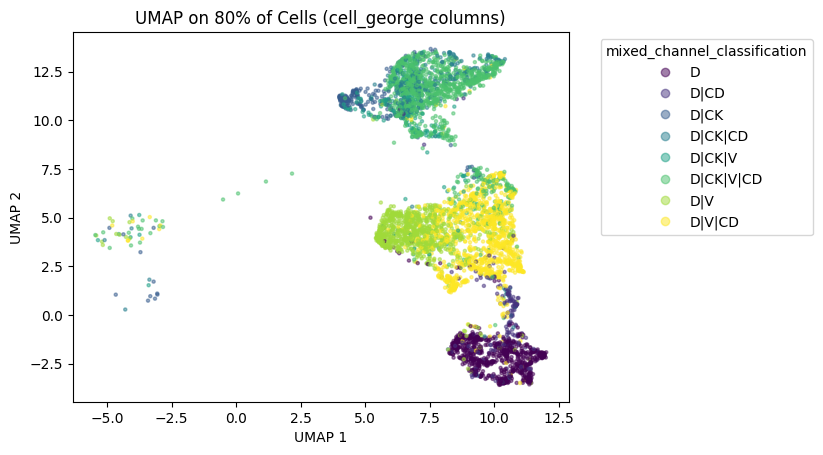

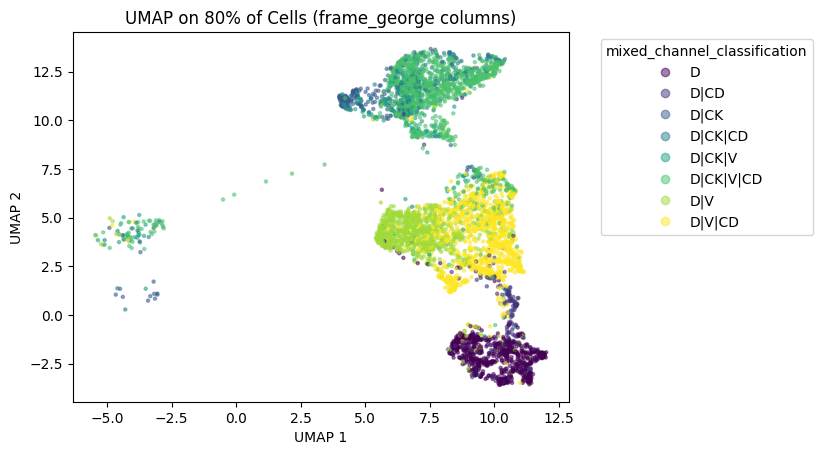

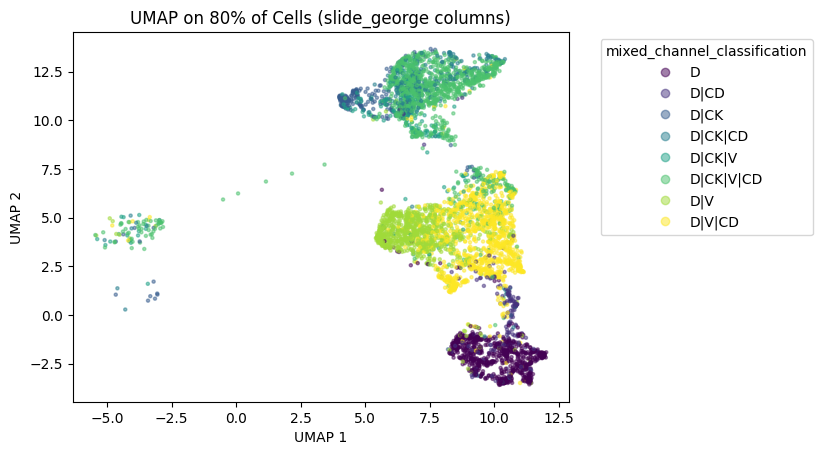

In [ ]:
y_col = 'mixed_channel_classification' # 'mixed_channel_classification'
for cols, umap, name in zip(X_cols, umaps, names):
  UMAP_plot(umap, dp_dict_all['multi']['X']['train'][cols], dp_dict_all['multi']['NotX']['train'][y_col], 'Cells', name, y_col)

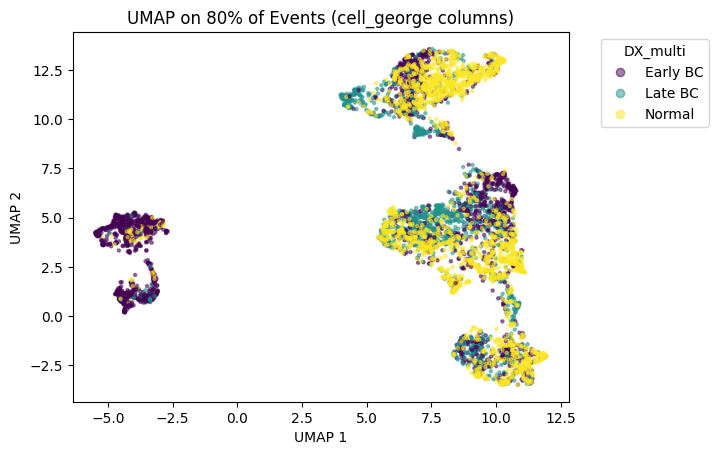

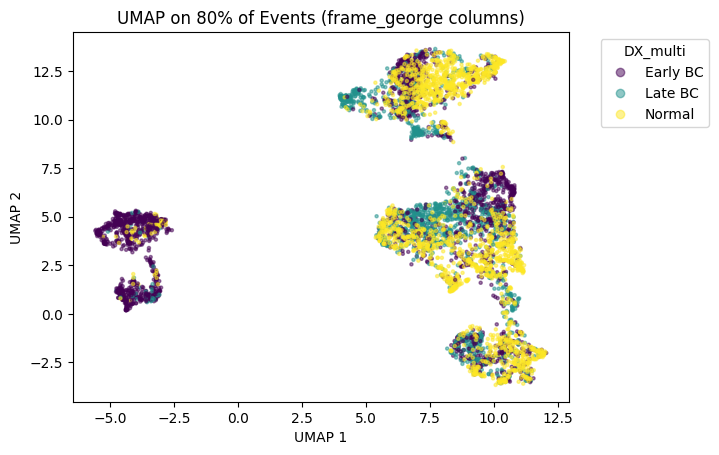

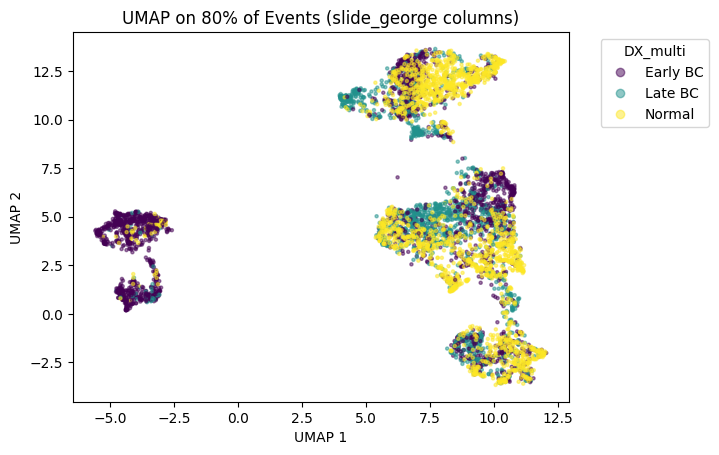

In [ ]:
y_col = 'DX_multi' # 'mixed_channel_classification'
for cols, event_umap, name in zip(X_cols, event_umaps, names):
  UMAP_plot(event_umap, events_dict_all['multi']['X']['train'][cols], events_dict_all['multi']['NotX']['train'][y_col], 'Events', name, y_col)

In [ ]:
from sklearn.svm import SVC
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
c_values = [100, 10, 1.0, 0.1, 0.001]
SVM_grid = dict(kernel=kernels, C=c_values)

In [ ]:
SVM_screen_dp_george, SVM_screen_dp_george_params = hyp_train(SVC(probability=True), {'C': [1.0], 'kernel': ['rbf']}, dp_dict_all['screen']['X']['train'][dp_cell_george_X_cols], dp_dict_all['screen']['y']['train'], dp_dict_all['screen']['NotX']['train']['patient_id'])
SVM_screen_dp_george_under, SVM_screen_dp_george_under_params = hyp_train(SVC(probability=True), {'C': [1.0], 'kernel': ['rbf']}, dp_dict_all['screen']['X']['train_RandomUnderSampler'][dp_cell_george_X_cols], dp_dict_all['screen']['y']['train_RandomUnderSampler'], dp_dict_all['screen']['NotX']['train_RandomUnderSampler']['patient_id'])
SVM_screen_dp_george_over, SVM_screen_dp_george_over_params = hyp_train(SVC(probability=True), {'C': [1.0], 'kernel': ['rbf']}, dp_dict_all['screen']['X']['train_RandomOverSampler'][dp_cell_george_X_cols], dp_dict_all['screen']['y']['train_RandomOverSampler'], dp_dict_all['screen']['NotX']['train_RandomOverSampler']['patient_id'])
SVM_screen_dp_george_tomek, SVM_screen_dp_george_tomek_params = hyp_train(SVC(probability=True), {'C': [1.0], 'kernel': ['rbf']}, dp_dict_all['screen']['X']['train_TomekLinks'][dp_cell_george_X_cols], dp_dict_all['screen']['y']['train_TomekLinks'], dp_dict_all['screen']['NotX']['train_TomekLinks']['patient_id'])

Best: 0.751241 using {'C': 1.0, 'kernel': 'rbf'}
Best: 0.726588 using {'C': 1.0, 'kernel': 'rbf'}
Best: 0.713900 using {'C': 1.0, 'kernel': 'rbf'}
Best: 0.751241 using {'C': 1.0, 'kernel': 'rbf'}


0.7120625942684766
              precision    recall  f1-score  support
0              0.424879  0.842949  0.564984    312.0
1              0.909761  0.581176  0.709261    850.0
micro avg      0.651463  0.651463  0.651463   1162.0
macro avg      0.667320  0.712063  0.637122   1162.0
weighted avg   0.779569  0.651463  0.670522   1162.0
samples avg    0.651463  0.651463  0.651463   1162.0


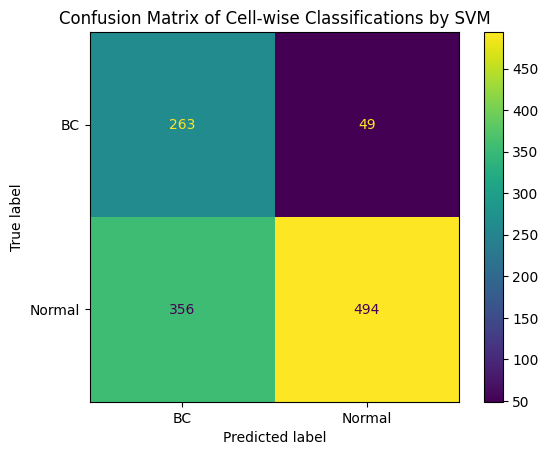

Average Patient Classification Accuracy: 0.8333333333333334
Average BC Patient Classification Accuracy: 0.9642857142857143
Average Normal Patient Classification Accuracy: 0.7368421052631579


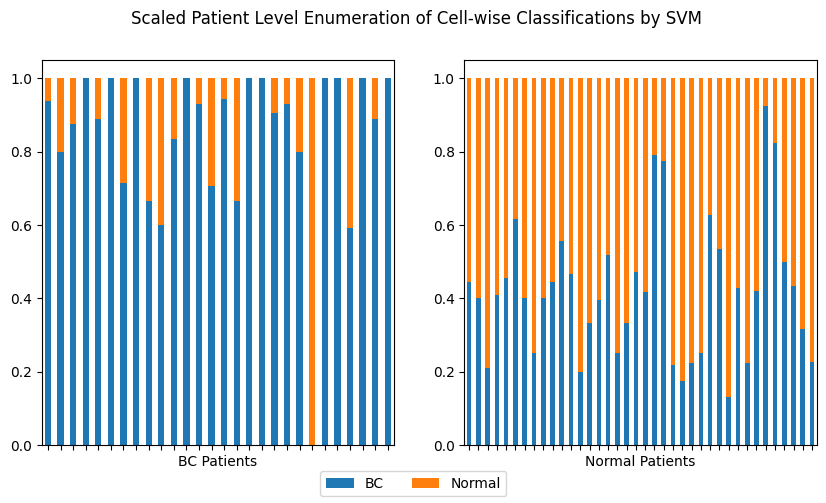

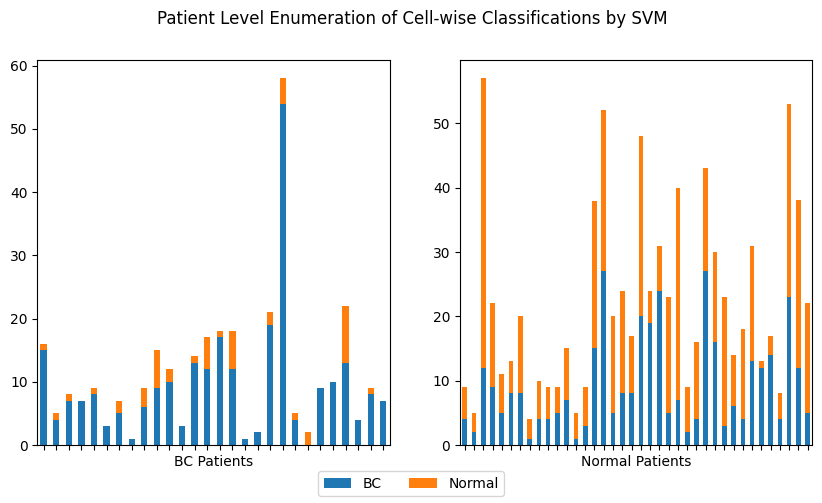

Average Patient Classification Accuracy: 0.8333333333333334


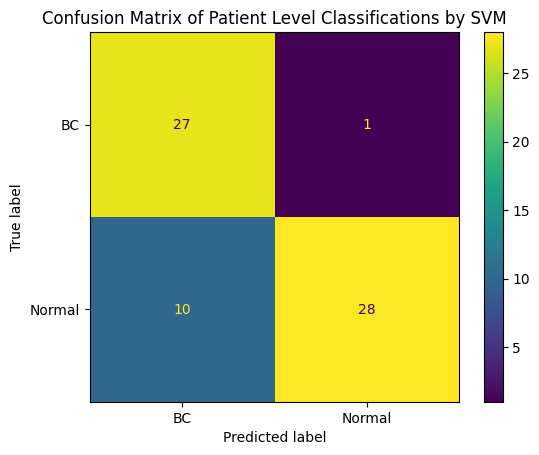

In [ ]:
cell_level_y_pred_analysis(SVM_screen_dp_george_tomek, 'SVM', dp_dict_all['screen']['X']['test'][dp_cell_george_X_cols], dp_dict_all['screen']['y']['test'])
patient_level_y_pred_analysis(SVM_screen_dp_george_tomek, 'SVM', dp_dict_all['screen']['X']['test'][dp_cell_george_X_cols], dp_dict_all['screen']['NotX']['test'], patient_col = 'slide_id')
patient_level_conf_matrix(SVM_screen_dp_george_tomek, 'SVM', dp_dict_all['screen']['X']['test'][dp_cell_george_X_cols], dp_dict_all['screen']['NotX']['test'], patient_col = 'slide_id')

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
RF_screen_dp_george_under, RF_screen_dp_george_under_params = hyp_train(RandomForestClassifier(), {'max_features': ['log2'], 'n_estimators': [1000]}, dp_dict_all['screen']['X']['train_RandomUnderSampler'][dp_cell_george_X_cols], dp_dict_all['screen']['y']['train_RandomUnderSampler'], dp_dict_all['screen']['NotX']['train_RandomUnderSampler']['patient_id'])

Best: 0.750827 using {'max_features': 'log2', 'n_estimators': 1000}


0.7463989441930619
              precision    recall  f1-score  support
0              0.527650  0.733974  0.613941    312.0
1              0.885989  0.758824  0.817490    850.0
micro avg      0.752151  0.752151  0.752151   1162.0
macro avg      0.706819  0.746399  0.715716   1162.0
weighted avg   0.789774  0.752151  0.762837   1162.0
samples avg    0.752151  0.752151  0.752151   1162.0


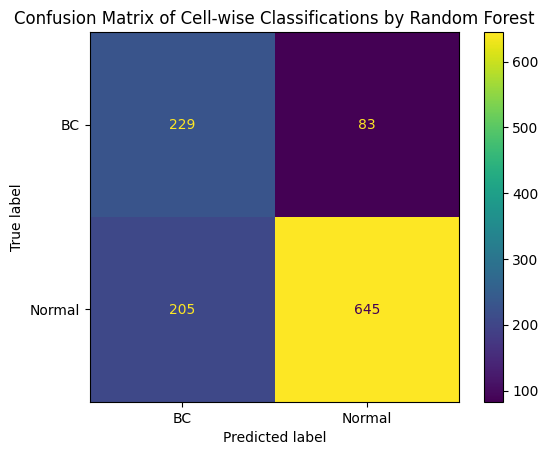

Average Patient Classification Accuracy: 0.8636363636363636
Average BC Patient Classification Accuracy: 0.8571428571428571
Average Normal Patient Classification Accuracy: 0.868421052631579


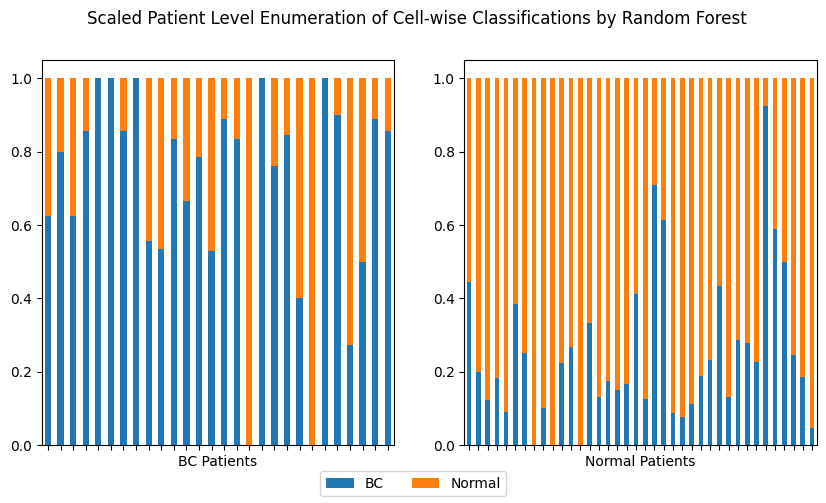

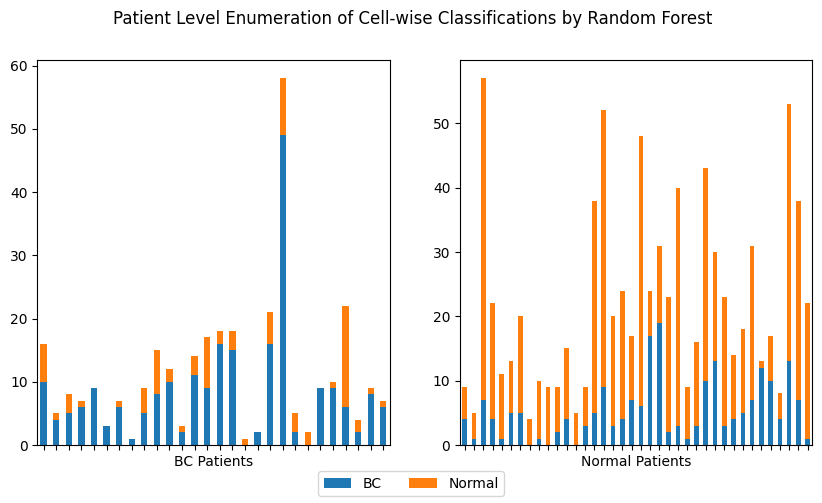

Average Patient Classification Accuracy: 0.8636363636363636


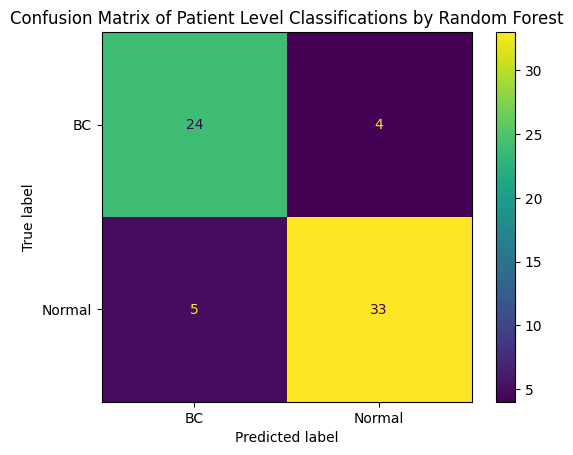

In [ ]:
cell_level_y_pred_analysis(RF_screen_dp_george_under, 'Random Forest', dp_dict_all['screen']['X']['test'][dp_cell_george_X_cols], dp_dict_all['screen']['y']['test'])
patient_level_y_pred_analysis(RF_screen_dp_george_under, 'Random Forest', dp_dict_all['screen']['X']['test'][dp_cell_george_X_cols], dp_dict_all['screen']['NotX']['test'], patient_col = 'slide_id')
patient_level_conf_matrix(RF_screen_dp_george_under, 'Random Forest', dp_dict_all['screen']['X']['test'][dp_cell_george_X_cols], dp_dict_all['screen']['NotX']['test'], patient_col = 'slide_id')

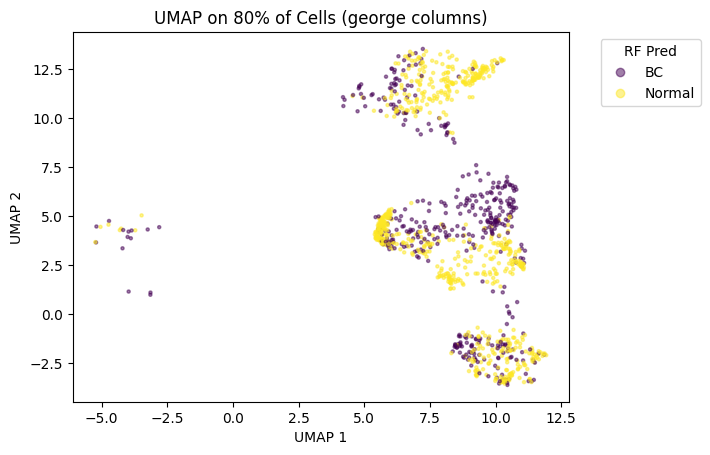

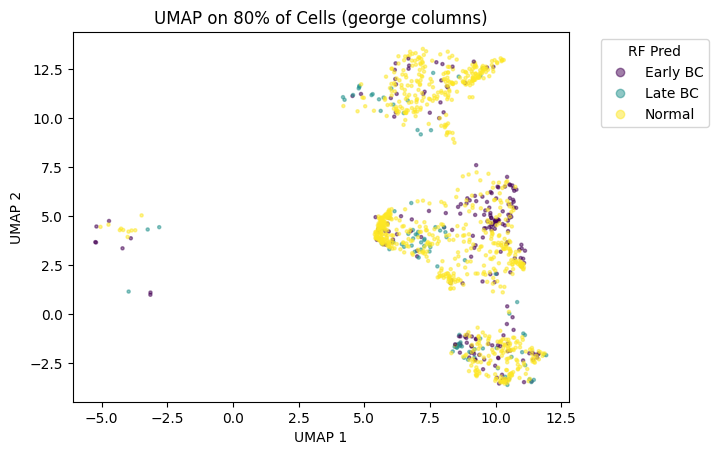

In [ ]:
y = RF_screen_dp_george_under.predict(dp_dict_all['multi']['X']['test'][dp_cell_george_X_cols])
UMAP_plot(X_umap_cell_george, dp_dict_all['multi']['X']['test'][dp_cell_george_X_cols], y, 'Cells', 'george', 'RF Pred')
UMAP_plot(X_umap_cell_george, dp_dict_all['multi']['X']['test'][dp_cell_george_X_cols], dp_dict_all['multi']['y']['test'], 'Cells', 'george', 'RF Pred')

In [ ]:
RF_screen_events_george_under, RF_screen_events_george_under_params = hyp_train(RandomForestClassifier(), {'max_features': ['log2'], 'n_estimators': [1000]}, events_dict_all['screen']['X']['train_RandomUnderSampler'][dp_george_X_cols], events_dict_all['screen']['y']['train_RandomUnderSampler'], events_dict_all['screen']['NotX']['train_RandomUnderSampler']['patient_id'])

In [ ]:
RF_screen_events_george, RF_screen_events_george_params = hyp_train(RandomForestClassifier(), {'max_features': ['log2'], 'n_estimators': [1000]}, events_dict_all['screen']['X']['train'][dp_george_X_cols], events_dict_all['screen']['y']['train'], events_dict_all['screen']['NotX']['train']['patient_id'])

In [ ]:
cell_level_y_pred_analysis(RF_screen_events_george, 'Random Forest', events_dict_all['screen']['X']['test'][dp_george_X_cols], events_dict_all['screen']['y']['test'])
patient_level_y_pred_analysis(RF_screen_events_george, 'Random Forest', events_dict_all['screen']['X']['test'][dp_george_X_cols], events_dict_all['screen']['NotX']['test'], patient_col = 'slide_id')
patient_level_conf_matrix(RF_screen_events_george, 'Random Forest', events_dict_all['screen']['X']['test'][dp_george_X_cols], events_dict_all['screen']['NotX']['test'], patient_col = 'slide_id')

In [ ]:
RF_screen_events_george_over, RF_screen_events_george_over_params = hyp_train(RandomForestClassifier(), {'max_features': ['log2'], 'n_estimators': [1000]}, events_dict_all['screen']['X']['train_RandomOverSampler'][dp_george_X_cols], events_dict_all['screen']['y']['train_RandomOverSampler'], events_dict_all['screen']['NotX']['train_RandomOverSampler']['patient_id'])

In [ ]:
cell_level_y_pred_analysis(RF_screen_events_george_over, 'Random Forest', events_dict_all['screen']['X']['test'][dp_george_X_cols], events_dict_all['screen']['y']['test'])
patient_level_y_pred_analysis(RF_screen_events_george_over, 'Random Forest', events_dict_all['screen']['X']['test'][dp_george_X_cols], events_dict_all['screen']['NotX']['test'], patient_col = 'slide_id')
patient_level_conf_matrix(RF_screen_events_george_over, 'Random Forest', events_dict_all['screen']['X']['test'][dp_george_X_cols], events_dict_all['screen']['NotX']['test'], patient_col = 'slide_id')

In [ ]:
cell_level_y_pred_analysis(RF_screen_events_george_under, 'Random Forest', events_dict_all['screen']['X']['test'][dp_george_X_cols], events_dict_all['screen']['y']['test'])
patient_level_y_pred_analysis(RF_screen_events_george_under, 'Random Forest', events_dict_all['screen']['X']['test'][dp_george_X_cols], events_dict_all['screen']['NotX']['test'], patient_col = 'slide_id')
patient_level_conf_matrix(RF_screen_events_george_under, 'Random Forest', events_dict_all['screen']['X']['test'][dp_george_X_cols], events_dict_all['screen']['NotX']['test'], patient_col = 'slide_id')

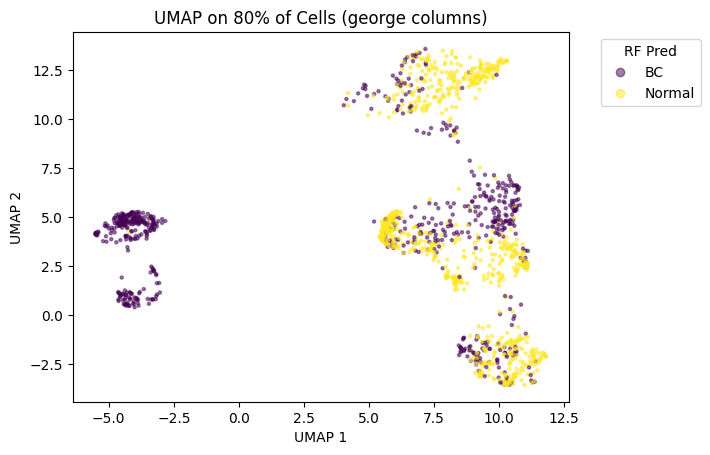

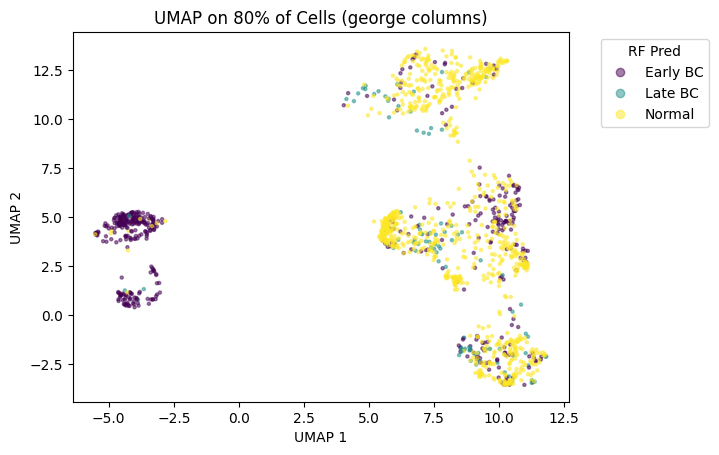

In [ ]:
y = RF_screen_events_george_under.predict(events_dict_all['multi']['X']['test'][dp_george_X_cols])
UMAP_plot(X_umap_events_george, events_dict_all['multi']['X']['test'][dp_george_X_cols], y, 'Cells', 'george', 'RF Pred')
UMAP_plot(X_umap_events_george, events_dict_all['multi']['X']['test'][dp_george_X_cols], events_dict_all['multi']['y']['test'], 'Cells', 'george', 'RF Pred')

In [ ]:
RF_multi_dp_george_under, RF_multi_dp_george_under_params = hyp_train(RandomForestClassifier(), {'max_features': ['log2'], 'n_estimators': [1000]}, dp_dict_all['multi']['X']['train_RandomUnderSampler'][dp_george_X_cols], dp_dict_all['multi']['y']['train_RandomUnderSampler'], dp_dict_all['multi']['NotX']['train_RandomUnderSampler']['patient_id'])

Best: 0.587822 using {'max_features': 'log2', 'n_estimators': 1000}


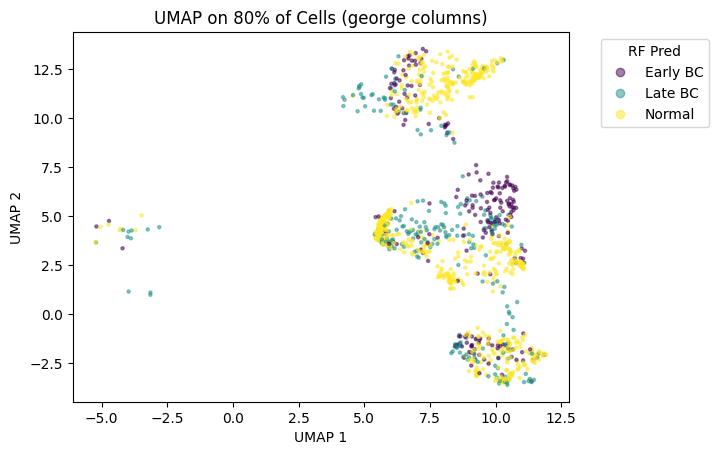

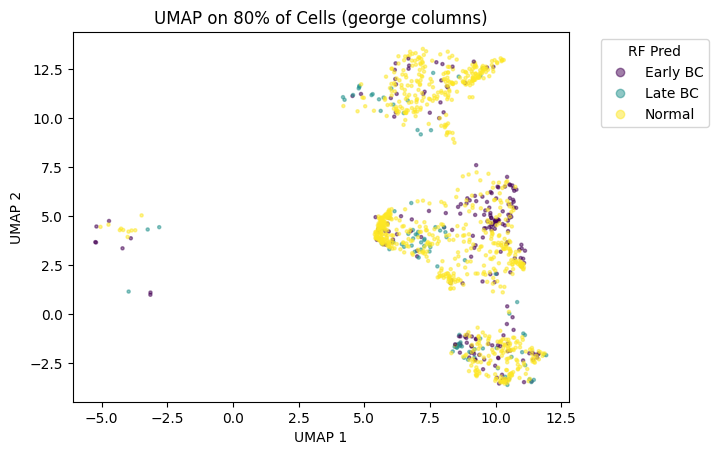

In [ ]:
y = RF_multi_dp_george_under.predict(dp_dict_all['multi']['X']['test'][dp_george_X_cols])
UMAP_plot(X_umap_george, dp_dict_all['multi']['X']['test'][dp_george_X_cols], y, 'Cells', 'george', 'RF Pred')
UMAP_plot(X_umap_george, dp_dict_all['multi']['X']['test'][dp_george_X_cols], dp_dict_all['multi']['y']['test'], 'Cells', 'george', 'RF Pred')

0.6962329950631085
              precision    recall  f1-score  support
0              0.369369  0.376147  0.372727    218.0
1              0.231939  0.648936  0.341737     94.0
2              0.896603  0.714118  0.795023    850.0
micro avg      0.645439  0.645439  0.645439   1162.0
macro avg      0.499304  0.579734  0.503162   1162.0
weighted avg   0.743922  0.645439  0.679128   1162.0
samples avg    0.645439  0.645439  0.645439   1162.0


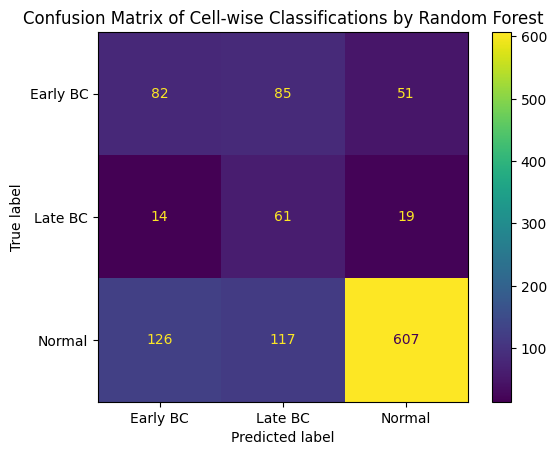

Average Patient Classification Accuracy: 0.7424242424242424
Average Early BC Patient Classification Accuracy: 0.45454545454545453
Average Late BC Patient Classification Accuracy: 1.0
Average Normal Patient Classification Accuracy: 0.868421052631579


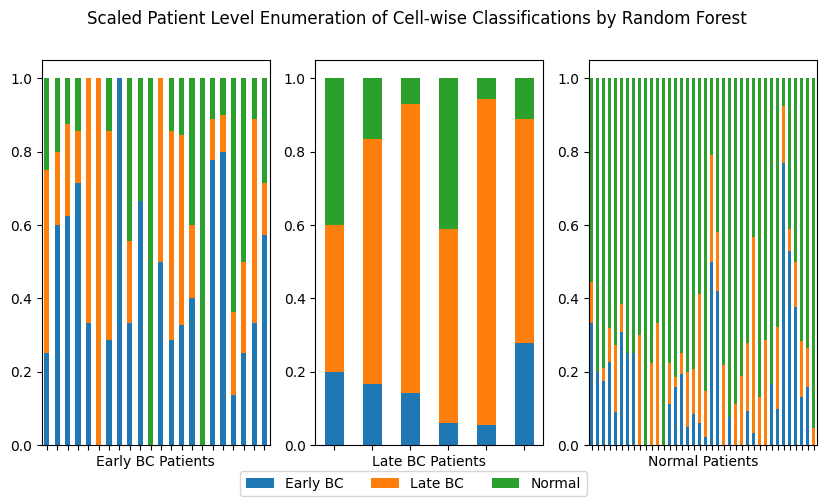

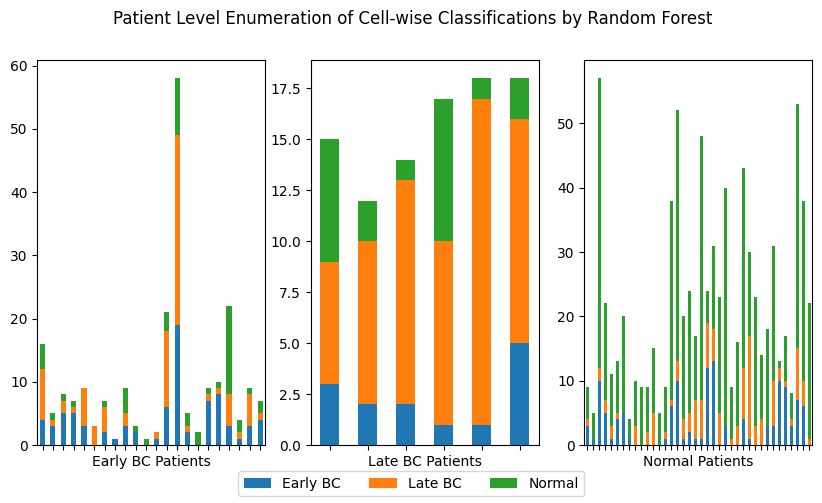

Average Patient Classification Accuracy: 0.7424242424242424


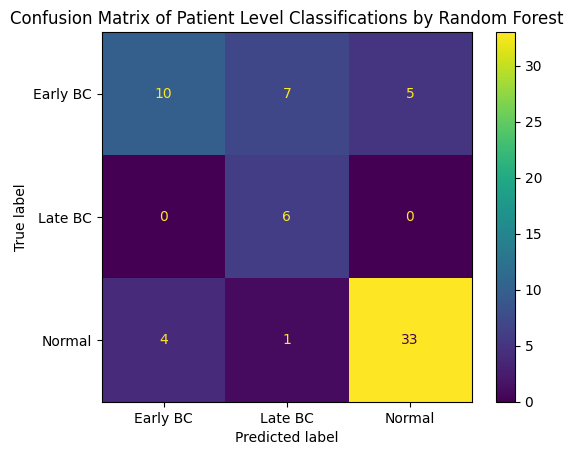

In [ ]:
cell_level_y_pred_analysis(RF_multi_dp_george_under, 'Random Forest', dp_dict_all['multi']['X']['test'][dp_george_X_cols], dp_dict_all['multi']['y']['test'])
patient_level_y_pred_analysis(RF_multi_dp_george_under, 'Random Forest', dp_dict_all['multi']['X']['test'][dp_george_X_cols], dp_dict_all['multi']['NotX']['test'], patient_col = 'slide_id')
patient_level_conf_matrix(RF_multi_dp_george_under, 'Random Forest', dp_dict_all['multi']['X']['test'][dp_george_X_cols], dp_dict_all['multi']['NotX']['test'], patient_col = 'slide_id')

In [ ]:
RF_multi_events_george_under, RF_multi_events_george_under_params = hyp_train(RandomForestClassifier(), {'max_features': ['log2'], 'n_estimators': [1000]}, events_dict_all['multi']['X']['train_RandomUnderSampler'][dp_george_X_cols], events_dict_all['multi']['y']['train_RandomUnderSampler'], events_dict_all['multi']['NotX']['train_RandomUnderSampler']['patient_id'])

Best: 0.611489 using {'max_features': 'log2', 'n_estimators': 1000}


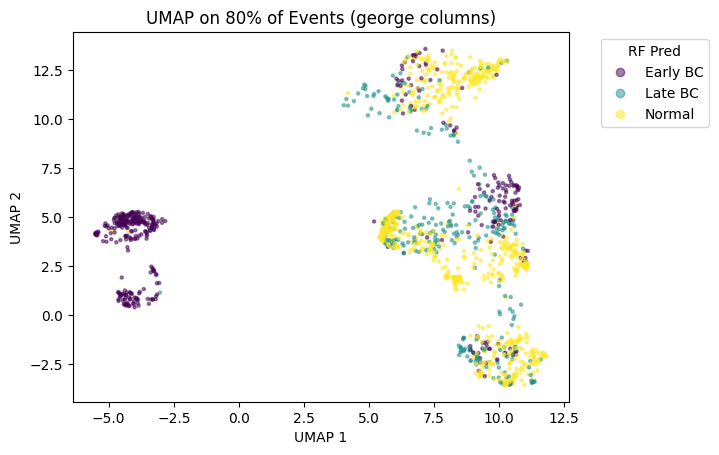

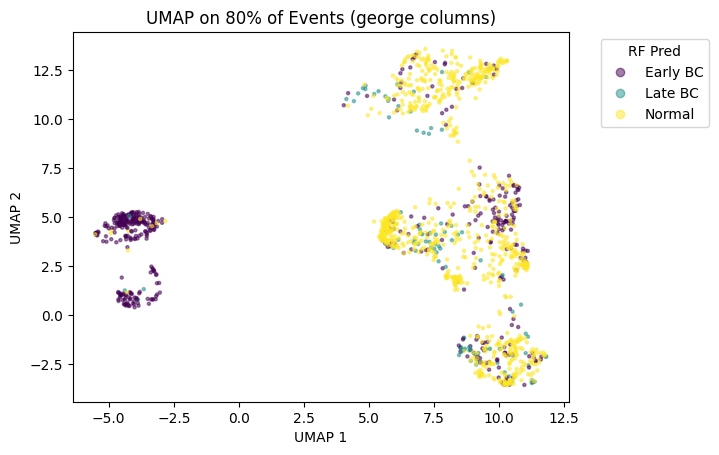

In [ ]:
y = RF_multi_events_george_under.predict(events_dict_all['multi']['X']['test'][dp_george_X_cols])
UMAP_plot(X_umap_events_george, events_dict_all['multi']['X']['test'][dp_george_X_cols], y, 'Events', 'george', 'RF Pred')
UMAP_plot(X_umap_events_george, events_dict_all['multi']['X']['test'][dp_george_X_cols], events_dict_all['multi']['y']['test'], 'Events', 'george', 'RF Pred')

In [ ]:
RF_stage_dp_george_under, RF_stage_dp_george_under_params = hyp_train(RandomForestClassifier(), {'max_features': ['log2'], 'n_estimators': [1000]}, dp_dict_all['stage']['X']['train_RandomUnderSampler'][dp_george_X_cols], dp_dict_all['stage']['y']['train_RandomUnderSampler'], dp_dict_all['stage']['NotX']['train_RandomUnderSampler']['patient_id'])

Best: 0.560408 using {'max_features': 'log2', 'n_estimators': 1000}


In [ ]:
RF_screen_dp_george_under_10, RF_screen_dp_george_under_10_params = hyp_train(RandomForestClassifier(), {'max_features': ['log2'], 'n_estimators': [10]}, dp_dict_all['screen']['X']['train_RandomUnderSampler'][dp_george_X_cols], dp_dict_all['screen']['y']['train_RandomUnderSampler'], dp_dict_all['screen']['NotX']['train_RandomUnderSampler']['patient_id'])

Best: 0.715141 using {'max_features': 'log2', 'n_estimators': 10}


In [ ]:
RF_multi_dp_george_under_10, RF_multi_dp_george_under_10_params = hyp_train(RandomForestClassifier(), {'max_features': ['log2'], 'n_estimators': [10]}, dp_dict_all['multi']['X']['train_RandomUnderSampler'][dp_george_X_cols], dp_dict_all['multi']['y']['train_RandomUnderSampler'], dp_dict_all['multi']['NotX']['train_RandomUnderSampler']['patient_id'])

Best: 0.546398 using {'max_features': 'log2', 'n_estimators': 10}


In [ ]:
RF_stage_dp_george_under_10, RF_stage_dp_george_under_10_params = hyp_train(RandomForestClassifier(), {'max_features': ['log2'], 'n_estimators': [10]}, dp_dict_all['stage']['X']['train_RandomUnderSampler'][dp_george_X_cols], dp_dict_all['stage']['y']['train_RandomUnderSampler'], dp_dict_all['stage']['NotX']['train_RandomUnderSampler']['patient_id'])

Best: 0.580316 using {'max_features': 'log2', 'n_estimators': 10}


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
KNN_screen_dp_all_under, KNN_screen_dp_all_under_params = hyp_train(KNeighborsClassifier(), {}, dp_dict_all['screen']['X']['train_RandomUnderSampler'], dp_dict_all['screen']['y']['train_RandomUnderSampler'], dp_dict_all['screen']['NotX']['train_RandomUnderSampler']['patient_id'])

Best: 0.839839 using {}


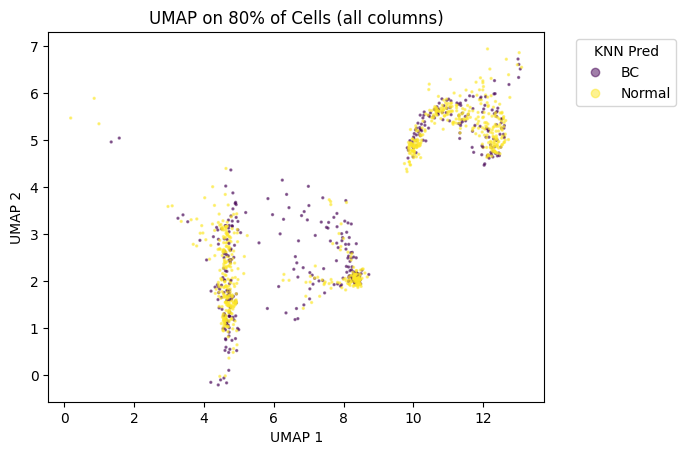

In [ ]:
y = KNN_screen_dp_all_under.predict(dp_dict_all['screen']['X']['test'][dp_all_X_cols])
UMAP_plot(X_umap_all, dp_dict_all['screen']['X']['test'][dp_all_X_cols], y, 'Cells', 'all', 'KNN Pred')

In [ ]:
!pip install numpy scipy scikit-learn pandas joblib pytorch
!pip install deap update_checker tqdm stopit xgboost
!pip install tpot

  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (pytorch)
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 5.4 MB/s eta 0:00:00
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11939 sha256=18935cb67b74f4383f137e547867a74c1dd17948e52e9abee32c23736076c299
  Stored in directory: /root/.cache/pip/wheels/af/f9/87/bf5b3d565c2a007b4dae9d8142dccc85a9f164e517062dd519
Successfully built stopit
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.4/87.4 kB 2.4 MB/s eta 0:00:00


In [ ]:
from tpot import TPOTClassifier

In [ ]:
tpot_screen_dp_george_under = TPOTClassifier()
tpot_screen_dp_george_under.fit(dp_dict_all['screen']['X']['train_RandomUnderSampler'][dp_george_X_cols], dp_dict_all['screen']['y']['train_RandomUnderSampler'])

TPOTClassifier()

In [ ]:
cell_level_y_pred_analysis(tpot_screen_dp_george_under, 'tpot', dp_dict_all['screen']['X']['test'][dp_george_X_cols], dp_dict_all['screen']['y']['test'])
patient_level_y_pred_analysis(tpot_screen_dp_george_under, 'tpot', dp_dict_all['screen']['X']['test'][dp_george_X_cols], dp_dict_all['screen']['NotX']['test'], patient_col = 'slide_id')
patient_level_conf_matrix(tpot_screen_dp_george_under, 'tpot', dp_dict_all['screen']['X']['test'][dp_george_X_cols], dp_dict_all['screen']['NotX']['test'], patient_col = 'slide_id')

NameError: name 'cell_level_y_pred_analysis' is not defined

0.8928167420814479
              precision    recall  f1-score  support
0              0.699519  0.932692  0.799451    312.0
1              0.971850  0.852941  0.908521    850.0
micro avg      0.874355  0.874355  0.874355   1162.0
macro avg      0.835685  0.892817  0.853986   1162.0
weighted avg   0.898728  0.874355  0.879236   1162.0
samples avg    0.874355  0.874355  0.874355   1162.0


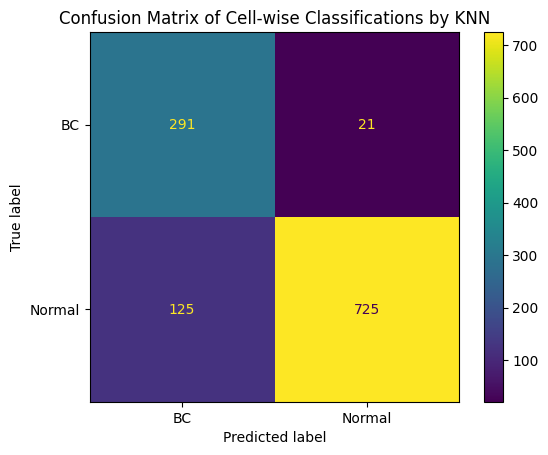

Average Patient Classification Accuracy: 0.8787878787878788
Average BC Patient Classification Accuracy: 0.8928571428571429
Average Normal Patient Classification Accuracy: 0.868421052631579


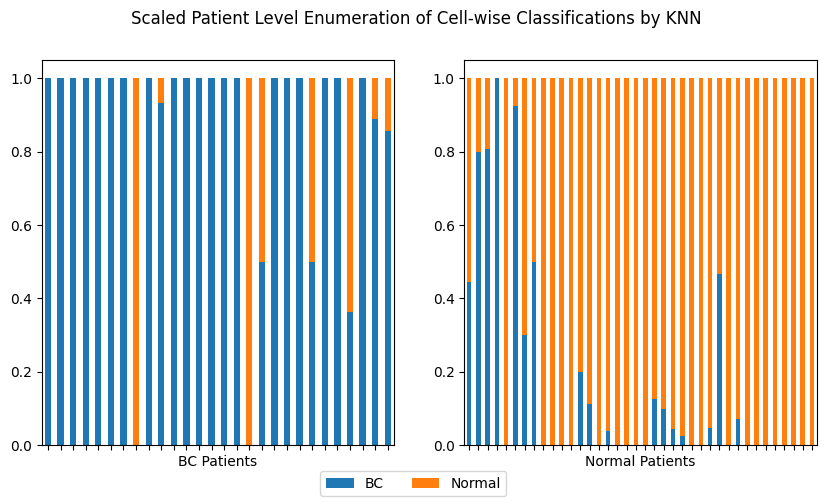

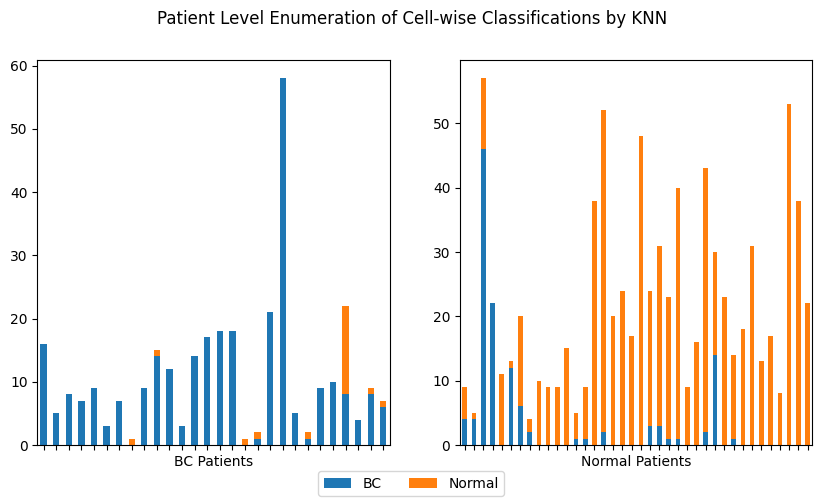

Average Patient Classification Accuracy: 0.8787878787878788


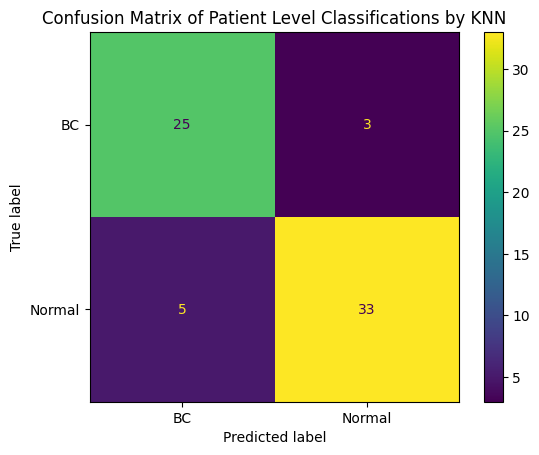

In [ ]:
cell_level_y_pred_analysis(KNN_screen_dp_all_under, 'KNN', dp_dict_all['screen']['X']['test'][dp_all_X_cols], dp_dict_all['screen']['y']['test'])
patient_level_y_pred_analysis(KNN_screen_dp_all_under, 'KNN', dp_dict_all['screen']['X']['test'][dp_all_X_cols], dp_dict_all['screen']['NotX']['test'], patient_col = 'slide_id')
patient_level_conf_matrix(KNN_screen_dp_all_under, 'KNN', dp_dict_all['screen']['X']['test'][dp_all_X_cols], dp_dict_all['screen']['NotX']['test'], patient_col = 'slide_id')

0.7577790346907993
              precision    recall  f1-score  support
0              0.537757  0.753205  0.627503    312.0
1              0.893793  0.762353  0.822857    850.0
micro avg      0.759897  0.759897  0.759897   1162.0
macro avg      0.715775  0.757779  0.725180   1162.0
weighted avg   0.798197  0.759897  0.770404   1162.0
samples avg    0.759897  0.759897  0.759897   1162.0


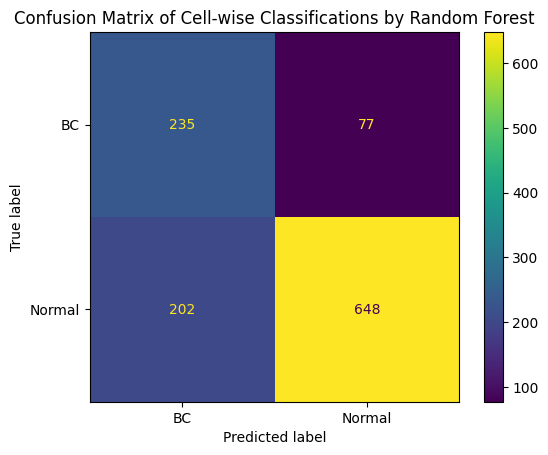

Average Patient Classification Accuracy: 0.8636363636363636
Average BC Patient Classification Accuracy: 0.8571428571428571
Average Normal Patient Classification Accuracy: 0.868421052631579


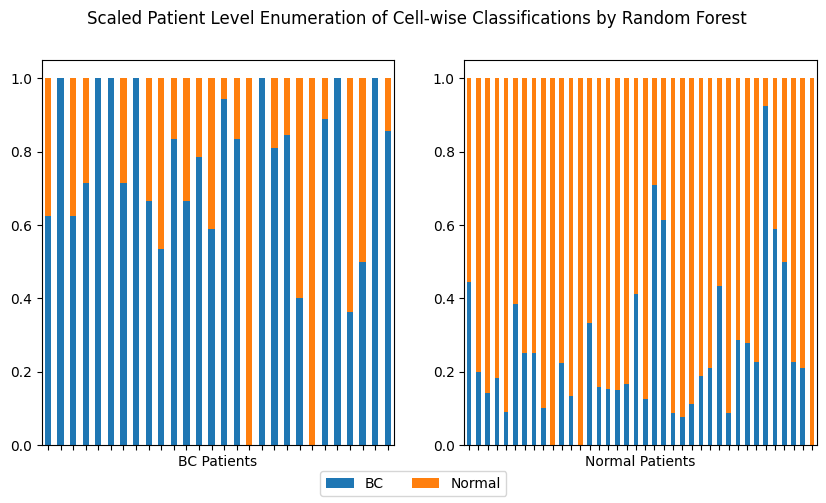

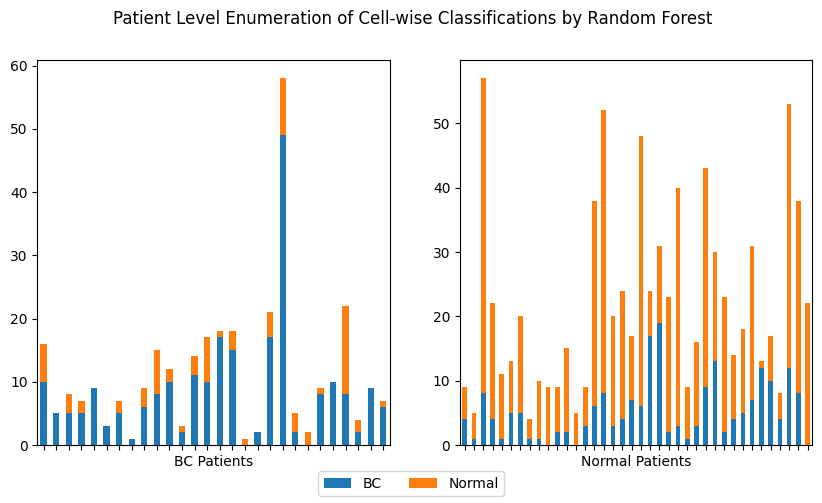

Average Patient Classification Accuracy: 0.8636363636363636


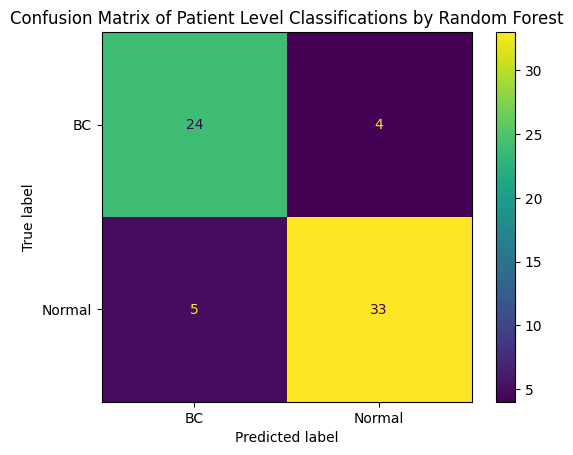

In [ ]:
cell_level_y_pred_analysis(RF_screen_dp_george_under, 'Random Forest', dp_dict_all['screen']['X']['test'][dp_george_X_cols], dp_dict_all['screen']['y']['test'])
patient_level_y_pred_analysis(RF_screen_dp_george_under, 'Random Forest', dp_dict_all['screen']['X']['test'][dp_george_X_cols], dp_dict_all['screen']['NotX']['test'], patient_col = 'slide_id')
patient_level_conf_matrix(RF_screen_dp_george_under, 'Random Forest', dp_dict_all['screen']['X']['test'][dp_george_X_cols], dp_dict_all['screen']['NotX']['test'], patient_col = 'slide_id')

0.7146757164404223
              precision    recall  f1-score  support
0              0.459144  0.756410  0.571429    312.0
1              0.882716  0.672941  0.763685    850.0
micro avg      0.695353  0.695353  0.695353   1162.0
macro avg      0.670930  0.714676  0.667557   1162.0
weighted avg   0.768986  0.695353  0.712064   1162.0
samples avg    0.695353  0.695353  0.695353   1162.0


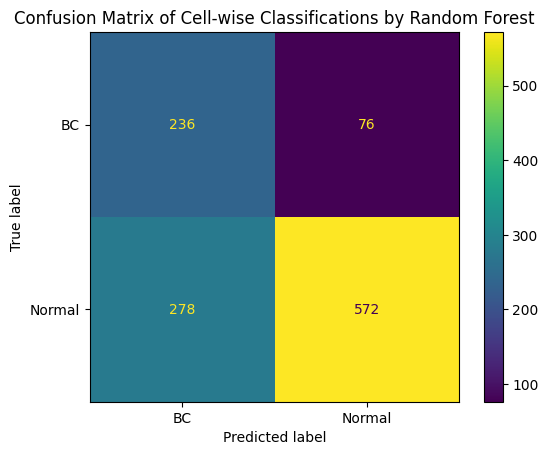

Average Patient Classification Accuracy: 0.8484848484848485
Average BC Patient Classification Accuracy: 0.9285714285714286
Average Normal Patient Classification Accuracy: 0.7894736842105263


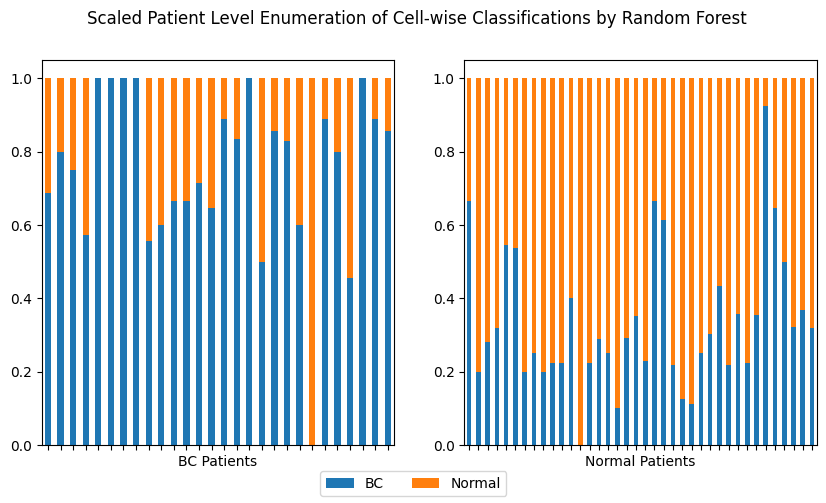

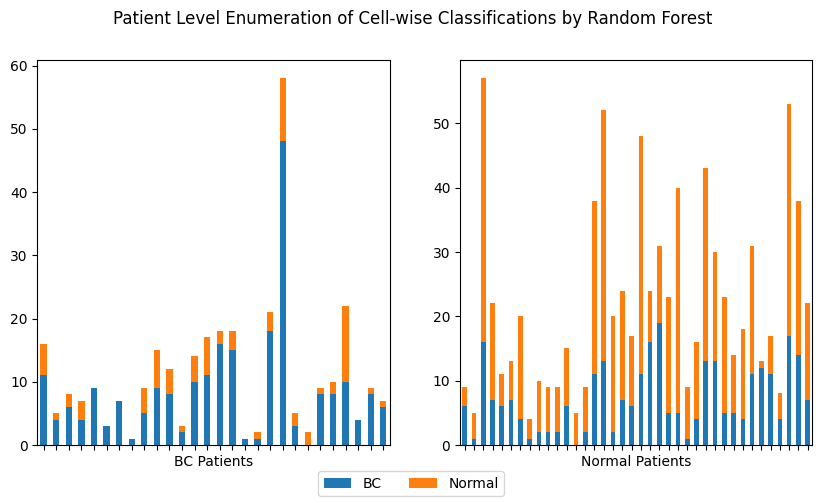

Average Patient Classification Accuracy: 0.8484848484848485


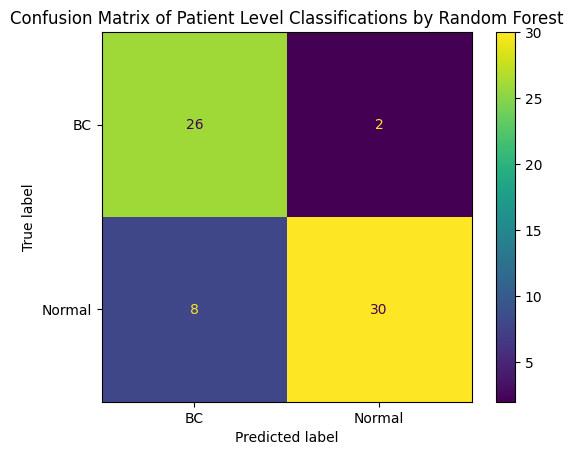

In [ ]:
cell_level_y_pred_analysis(RF_screen_dp_george_under_10, 'Random Forest', dp_dict_all['screen']['X']['test'][dp_george_X_cols], dp_dict_all['screen']['y']['test'])
patient_level_y_pred_analysis(RF_screen_dp_george_under_10, 'Random Forest', dp_dict_all['screen']['X']['test'][dp_george_X_cols], dp_dict_all['screen']['NotX']['test'], patient_col = 'slide_id')
patient_level_conf_matrix(RF_screen_dp_george_under_10, 'Random Forest', dp_dict_all['screen']['X']['test'][dp_george_X_cols], dp_dict_all['screen']['NotX']['test'], patient_col = 'slide_id')

0.6992593752383903
              precision    recall  f1-score  support
0              0.372807  0.389908  0.381166    218.0
1              0.240157  0.648936  0.350575     94.0
2              0.895588  0.716471  0.796078    850.0
micro avg      0.649742  0.649742  0.649742   1162.0
macro avg      0.502851  0.585105  0.509273   1162.0
weighted avg   0.744489  0.649742  0.682199   1162.0
samples avg    0.649742  0.649742  0.649742   1162.0


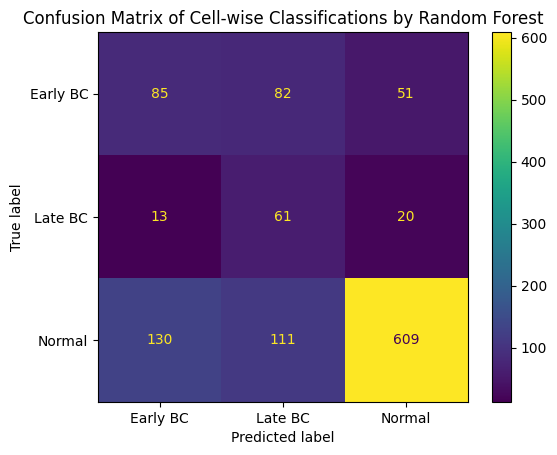

Average Patient Classification Accuracy: 0.7878787878787878
Average Early BC Patient Classification Accuracy: 0.5909090909090909
Average Late BC Patient Classification Accuracy: 1.0
Average Normal Patient Classification Accuracy: 0.868421052631579


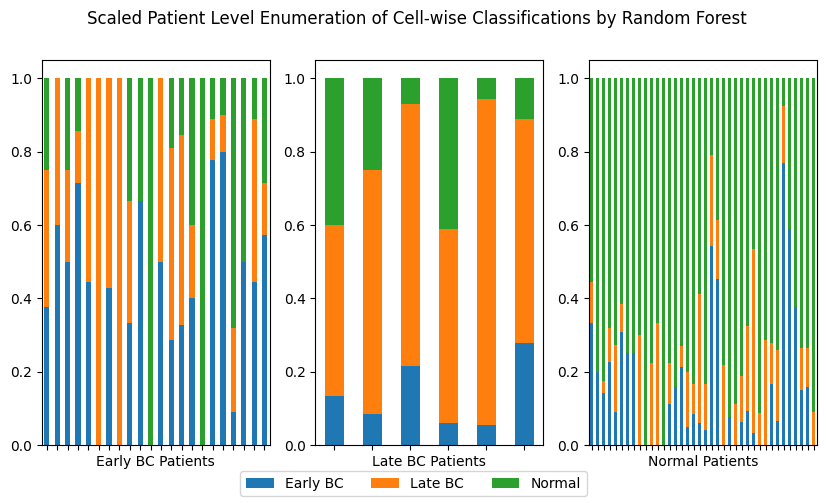

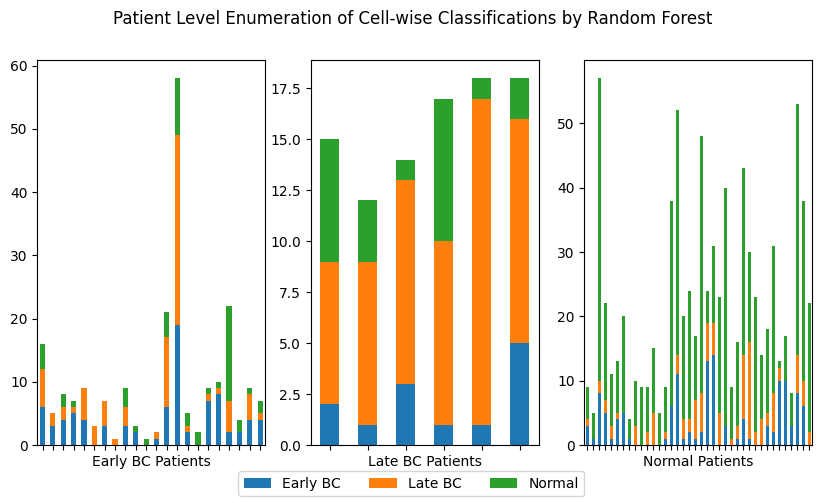

Average Patient Classification Accuracy: 0.7878787878787878


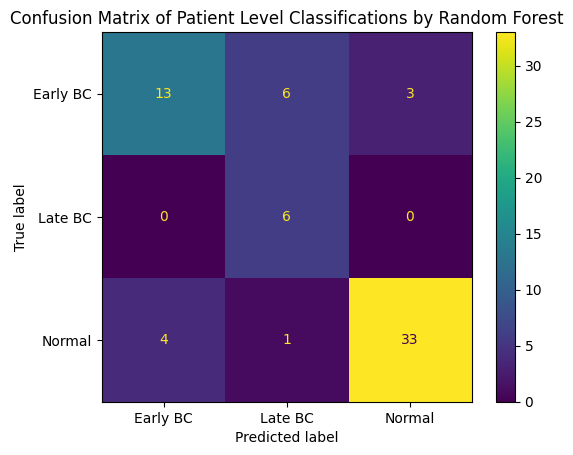

In [ ]:
cell_level_y_pred_analysis(RF_multi_dp_george_under, 'Random Forest', dp_dict_all['multi']['X']['test'][dp_george_X_cols], dp_dict_all['multi']['y']['test'])
patient_level_y_pred_analysis(RF_multi_dp_george_under, 'Random Forest', dp_dict_all['multi']['X']['test'][dp_george_X_cols], dp_dict_all['multi']['NotX']['test'], patient_col = 'slide_id')
patient_level_conf_matrix(RF_multi_dp_george_under, 'Random Forest', dp_dict_all['multi']['X']['test'][dp_george_X_cols], dp_dict_all['multi']['NotX']['test'], patient_col = 'slide_id')

0.6818184263869007
              precision    recall  f1-score  support
0              0.311377  0.477064  0.376812    218.0
1              0.224000  0.595745  0.325581     94.0
2              0.906574  0.616471  0.733894    850.0
micro avg      0.588640  0.588640  0.588640   1162.0
macro avg      0.480651  0.563093  0.478762   1162.0
weighted avg   0.739694  0.588640  0.633872   1162.0
samples avg    0.588640  0.588640  0.588640   1162.0


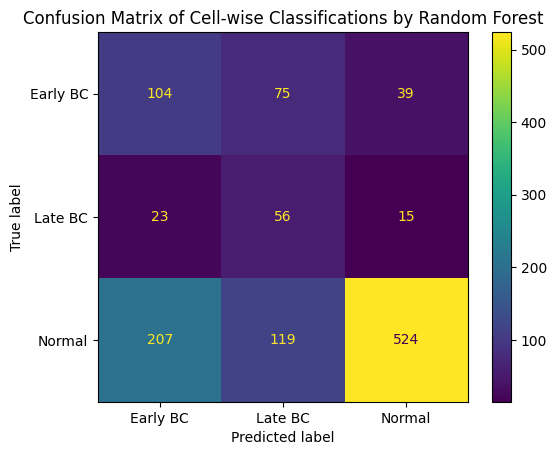

Average Patient Classification Accuracy: 0.7424242424242424
Average Early BC Patient Classification Accuracy: 0.5909090909090909
Average Late BC Patient Classification Accuracy: 0.8333333333333334
Average Normal Patient Classification Accuracy: 0.8157894736842105


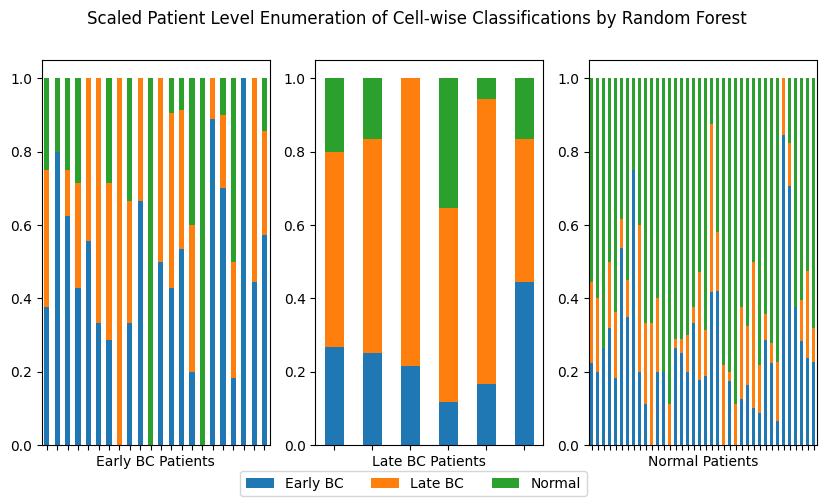

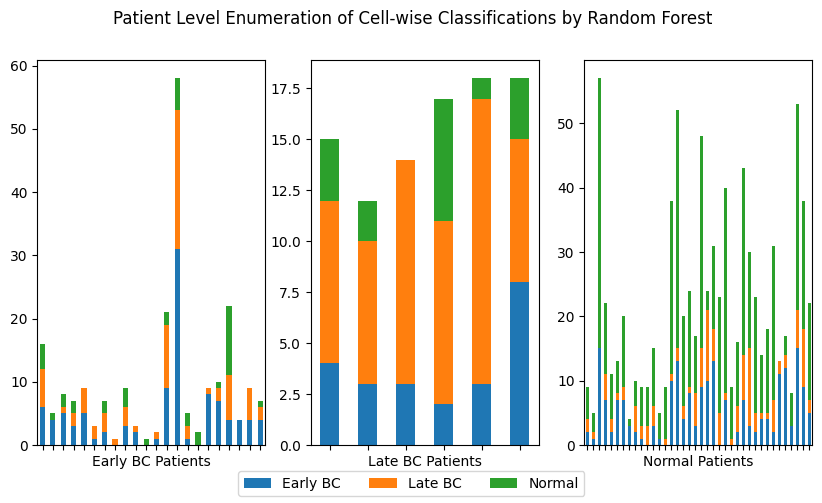

Average Patient Classification Accuracy: 0.7424242424242424


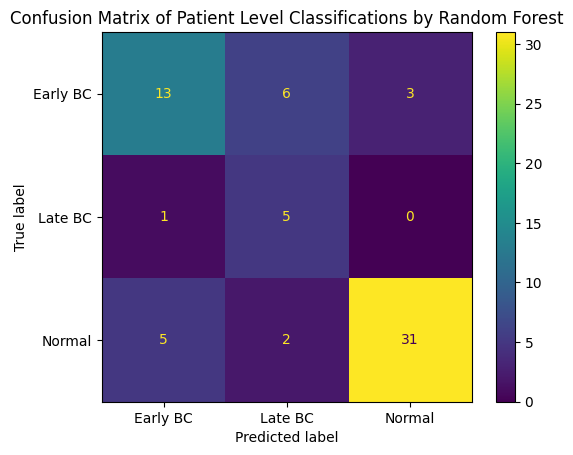

In [ ]:
cell_level_y_pred_analysis(RF_multi_dp_george_under_10, 'Random Forest', dp_dict_all['multi']['X']['test'][dp_george_X_cols], dp_dict_all['multi']['y']['test'])
patient_level_y_pred_analysis(RF_multi_dp_george_under_10, 'Random Forest', dp_dict_all['multi']['X']['test'][dp_george_X_cols], dp_dict_all['multi']['NotX']['test'], patient_col = 'slide_id')
patient_level_conf_matrix(RF_multi_dp_george_under_10, 'Random Forest', dp_dict_all['multi']['X']['test'][dp_george_X_cols], dp_dict_all['multi']['NotX']['test'], patient_col = 'slide_id')

0.6345192419486106
              precision    recall  f1-score  support
0              0.903448  0.715847  0.798780    549.0
1              0.250000  0.553191  0.344371     94.0
micro avg      0.692068  0.692068  0.692068    643.0
macro avg      0.576724  0.634519  0.571576    643.0
weighted avg   0.807921  0.692068  0.732350    643.0
samples avg    0.692068  0.692068  0.692068    643.0


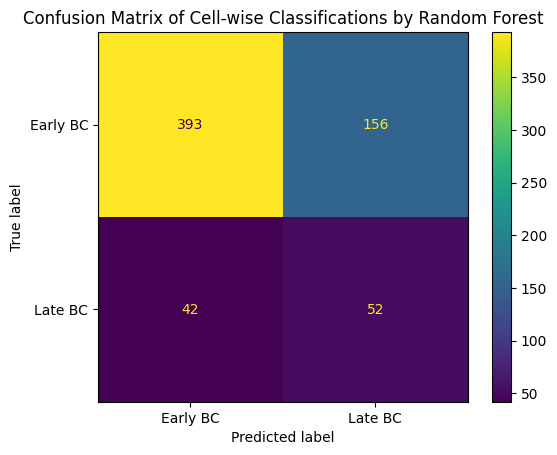

Average Patient Classification Accuracy: 0.7222222222222222
Average Early BC Patient Classification Accuracy: 0.8214285714285714
Average Late BC Patient Classification Accuracy: 0.375


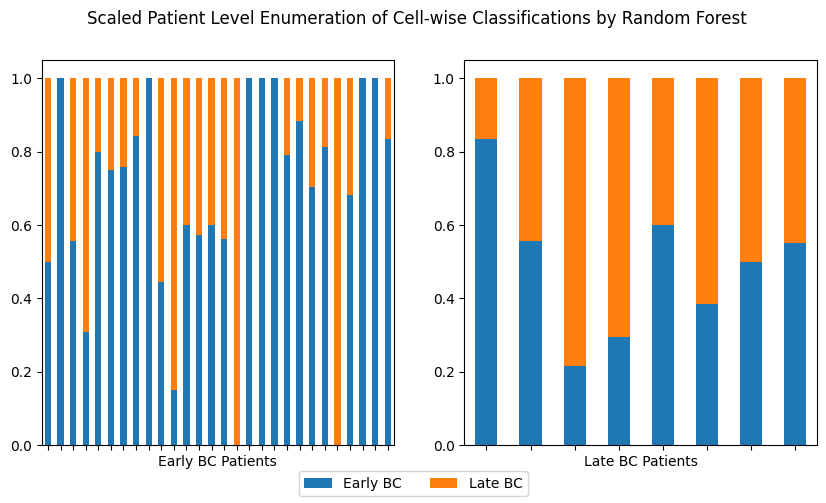

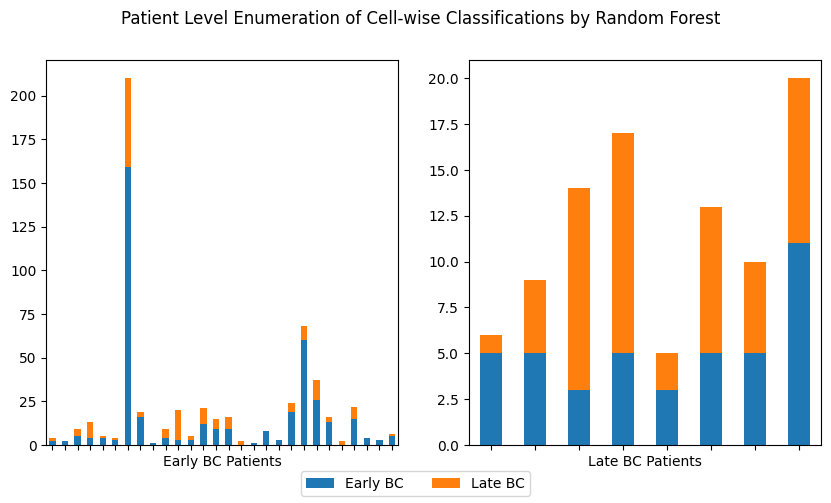

Average Patient Classification Accuracy: 0.7222222222222222


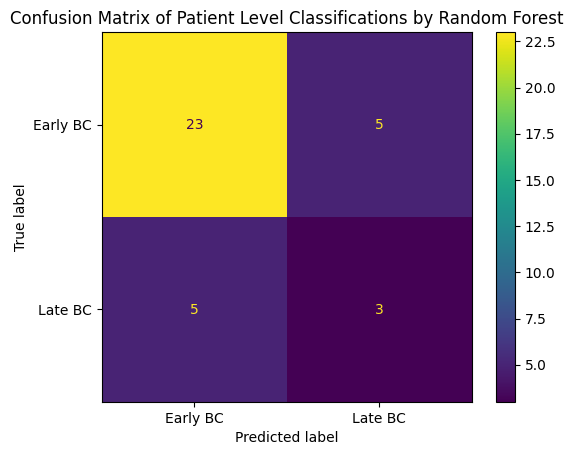

In [ ]:
cell_level_y_pred_analysis(RF_stage_dp_george_under, 'Random Forest', dp_dict_all['stage']['X']['test'][dp_george_X_cols], dp_dict_all['stage']['y']['test'])
patient_level_y_pred_analysis(RF_stage_dp_george_under, 'Random Forest', dp_dict_all['stage']['X']['test'][dp_george_X_cols], dp_dict_all['stage']['NotX']['test'], patient_col = 'slide_id')
patient_level_conf_matrix(RF_stage_dp_george_under, 'Random Forest', dp_dict_all['stage']['X']['test'][dp_george_X_cols], dp_dict_all['stage']['NotX']['test'], patient_col = 'slide_id')

0.6396543037631284
              precision    recall  f1-score  support
0              0.901709  0.768670  0.829892    549.0
1              0.274286  0.510638  0.356877     94.0
micro avg      0.730949  0.730949  0.730949    643.0
macro avg      0.587998  0.639654  0.593385    643.0
weighted avg   0.809986  0.730949  0.760742    643.0
samples avg    0.730949  0.730949  0.730949    643.0


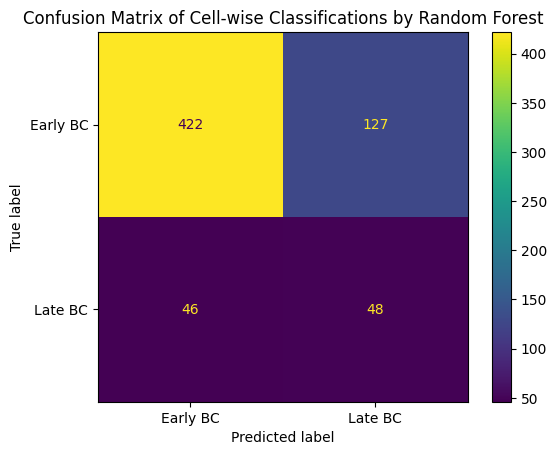

Average Patient Classification Accuracy: 0.8611111111111112
Average Early BC Patient Classification Accuracy: 1.0
Average Late BC Patient Classification Accuracy: 0.375


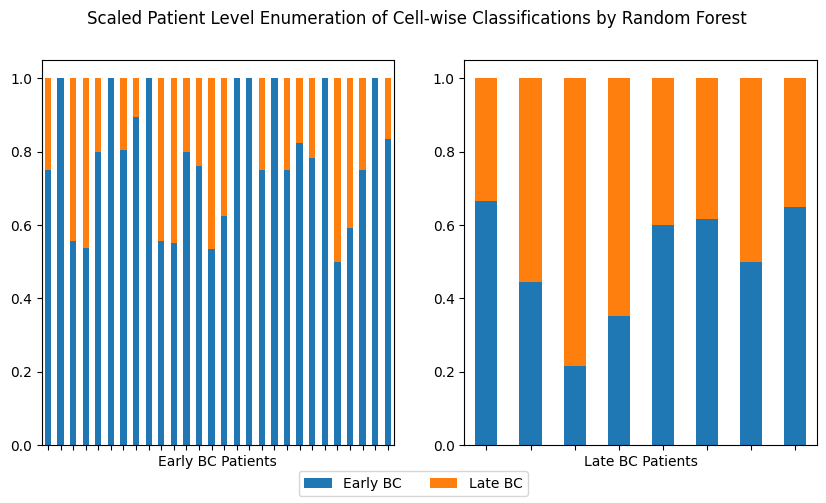

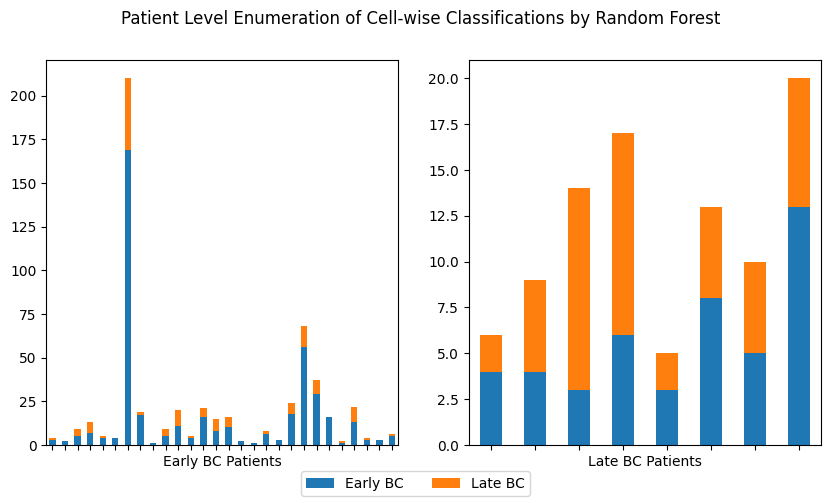

Average Patient Classification Accuracy: 0.8611111111111112


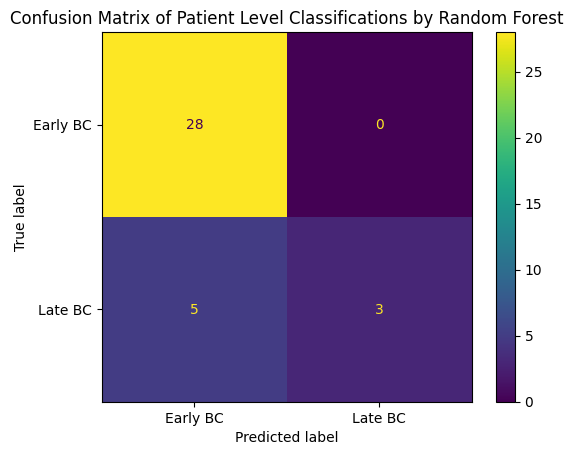

In [ ]:
cell_level_y_pred_analysis(RF_stage_dp_george_under_10, 'Random Forest', dp_dict_all['stage']['X']['test'][dp_george_X_cols], dp_dict_all['stage']['y']['test'])
patient_level_y_pred_analysis(RF_stage_dp_george_under_10, 'Random Forest', dp_dict_all['stage']['X']['test'][dp_george_X_cols], dp_dict_all['stage']['NotX']['test'], patient_col = 'slide_id')
patient_level_conf_matrix(RF_stage_dp_george_under_10, 'Random Forest', dp_dict_all['stage']['X']['test'][dp_george_X_cols], dp_dict_all['stage']['NotX']['test'], patient_col = 'slide_id')